In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


https://github.com/kiyoungkim1/LMkor

Data

국내 주요 커머스 리뷰 1억개 + 블로그 형 웹사이트 2000만개 (75GB)
모두의 말뭉치 (18GB)
위키피디아와 나무위키 (6GB)
불필요하거나 너무 짤은 문장, 중복되는 문장 제외, 100GB의 데이터 중 최종 70GB (약 127억개의 token) 텍스트 데이터 학습

화장품(8GB), 식품(6GB), 전자제품(13GB), 반려동물(2GB) 등등의 카테고리로 분류, 도메인 특화 언어모델 학습에 사용

Vocab

tokenizer는 Huggingface tokneinzers wordpiece로 통일, 400000개 subword
한글, 영어, 숫자와 일부 특수문자를 제외한 문자는 삭제(예시: 한자, 이모지 등)
Pretrained Models: Transformers 라이브러리를 통해 사용가능하도록 만들었음

encoder 기반(BERT 등)
decoder 기반(GPT3) 모델 초기 버전에 추가 -> 문장 생성 https://colab.research.google.com/github/kiyoungkim1/LMkor/blob/main/notebooks/gpt3_text_generation.ipynb (2021.01)
encoder-decoder(T5, BERTSHARED) Bert 기반 seq2seq 모델 -> 문서 요약 https://colab.research.google.com/github/kiyoungkim1/LMkor/blob/main/notebooks/summarization_with_bertshared.ipynb


#Data Load

In [1]:
import pandas as pd

path = 'melonlyric.pkl'
df = pd.read_pickle(path)
df.head()

,pages,rank,title,lyric,artist,genres,writer
0,1,1,사랑인가 봐,"너와 함께 하고 싶은 일들을,상상하는 게,요즘 내 일상이 되고,너의 즐거워하는 모습...",멜로망스,"발라드, 국내드라마",김민석 (멜로망스)
1,1,2,취중고백,"뭐하고 있었니 늦었지만,잠시 나올래,너의 집 골목에 있는,놀이터에 앉아 있어,친구들...",김민석 (멜로망스),발라드,김희탐
2,1,3,듣고 싶을까,"우리 함께 듣던 그 노랠 듣고 싶을까,듣고 나서 잠시 날 생각은 할까,아주 혹시라도...",MSG워너비(M.O.M),발라드,Dr.JO
3,1,4,사랑은 늘 도망가,"눈물이 난다 이 길을 걸으면,그 사람 손길이 자꾸 생각이 난다,붙잡지 못하고 가슴만...",임영웅,"발라드, 국내드라마",강태규
4,1,5,언제나 사랑해,"둘이 손잡고 걸을 때,마주 보며 또 웃을 때,사랑한다 말하지 않아도 알아,널 만나러...",케이시 (Kassy),발라드,조영수


In [2]:
df['genres_1'] = df['genres'].str.split(',',0).str[0]

In [3]:
df['lyric'] = df.lyric.apply(lambda x: x.replace(',' ,'<br>'))

In [4]:
# 세대별 토큰 넣어주기

df['<'] = '<'
df['>'] = '> '
df['lyric'] = df['<'] + df['genres_1'] + df['>'] + df['lyric']
df.head()

,pages,rank,title,lyric,artist,genres,writer,genres_1,<,>
0,1,1,사랑인가 봐,<발라드> 너와 함께 하고 싶은 일들을<br>상상하는 게<br>요즘 내 일상이 되고...,멜로망스,"발라드, 국내드라마",김민석 (멜로망스),발라드,<,>
1,1,2,취중고백,<발라드> 뭐하고 있었니 늦었지만<br>잠시 나올래<br>너의 집 골목에 있는<br...,김민석 (멜로망스),발라드,김희탐,발라드,<,>
2,1,3,듣고 싶을까,<발라드> 우리 함께 듣던 그 노랠 듣고 싶을까<br>듣고 나서 잠시 날 생각은 할...,MSG워너비(M.O.M),발라드,Dr.JO,발라드,<,>
3,1,4,사랑은 늘 도망가,<발라드> 눈물이 난다 이 길을 걸으면<br>그 사람 손길이 자꾸 생각이 난다<br...,임영웅,"발라드, 국내드라마",강태규,발라드,<,>
4,1,5,언제나 사랑해,<발라드> 둘이 손잡고 걸을 때<br>마주 보며 또 웃을 때<br>사랑한다 말하지 ...,케이시 (Kassy),발라드,조영수,발라드,<,>


In [5]:
df1 = df.head(2500)
df2 = df.tail(2500)

In [6]:
df = pd.concat([df1,df2],ignore_index=True)

In [7]:
len(df)

5000

#Tokenizer

In [8]:
!pip install transformers

     ---------------------------------------- 4.0/4.0 MB 3.3 MB/s eta 0:00:00
     ---------------------------------------- 77.9/77.9 KB 2.2 MB/s eta 0:00:00
     ---------------------------------------- 3.3/3.3 MB 4.0 MB/s eta 0:00:00
     -------------------------------------- 895.2/895.2 KB 3.8 MB/s eta 0:00:00


- pretokenizer
- https://huggingface.co/docs/transformers/main_classes/tokenizer

In [9]:
# !pip install transformers
from transformers import BertTokenizerFast #, GPT2LMHeadModel
gens = ["<발라드>", "<댄스>"]
tokenizer_gpt3 = BertTokenizerFast.from_pretrained("kykim/gpt3-kor-small_based_on_gpt2", 
                                                   bos_token='<|startoftext|>', # representing the beginning of a sentence
                                                   eos_token='<|endoftext|>',  # representing the end of a sentence
                                                   pad_token='<|pad|>', # 배치 목적으로 동일한 사이즈의 토큰 배열(arrays)을 만들기 위해
                                                   additional_special_tokens=gens) # 분할되지 않도록 추가
 
tokenizer_gpt3.add_tokens("<br>")

# input_ids = tokenizer_gpt3.encode("text to tokenize")[1:]  # remove cls token

Downloading:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/336k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/615 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'BertTokenizer'.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'BertTokenizerFast'.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


1

In [10]:
print("The max model length is {} for this model, although the actual embedding size for GPT small is 768".format(tokenizer_gpt3.model_max_length))
print("The beginning of sequence token {} token has the id {}".format(tokenizer_gpt3.convert_ids_to_tokens(tokenizer_gpt3.bos_token_id), tokenizer_gpt3.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer_gpt3.convert_ids_to_tokens(tokenizer_gpt3.eos_token_id), tokenizer_gpt3.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer_gpt3.convert_ids_to_tokens(tokenizer_gpt3.pad_token_id), tokenizer_gpt3.pad_token_id))

The max model length is 2048 for this model, although the actual embedding size for GPT small is 768
The beginning of sequence token <|startoftext|> token has the id 42000
The end of sequence token <|endoftext|> has the id 42001
The padding token <|pad|> has the id 42002


#Pytorch Dataset & Dataloaders

1. br은 그대로 (or not)
2. 장르 토큰 추가할 것 - 모든 장르 대상 다 돌릴 것이므로 

In [11]:
import re
def preprocess(text):
    # <br> -> 양 옆에 스페이스 추가 
    text = re.sub(r"<br>", " <br> ", text)

    # 한영, \n, 숫자 제외 특수부호 제거 
    text = re.sub(r"[^ <>0-9a-zA-Zㄱ-힗]+", "", text)

    # 영어는 lowercase로
    text = text.lower()

    return text

In [12]:
# 예시 문장
ex = preprocess(df['lyric'][0])
print(ex)
print(tokenizer_gpt3.encode('<|startoftext|>'+ex, # The first sequence to be encoded
      truncation=True, # 잘림 허용
      max_length=350, 
      padding="max_length")[1:]) #Pad to a maximum length specified with the argument max_length or
                                 # to the maximum acceptable input length for the model if that argument is not provided

<발라드> 너와 함께 하고 싶은 일들을 <br> 상상하는 게 <br> 요즘 내 일상이 되고 <br> 너의 즐거워하는 모습을 보고 있으면 <br> 자연스레 따라 웃고 있는 걸 <br> 너의 행동에 설레어하고 뒤척이다가 <br> 지새운 밤이 많아지는데 <br> 이건 누가 봐도 사랑일 텐데 <br> 종일 함께면 질릴 텐데 <br> 나 돌아서도 온통 너인 건 <br> 아무래도 사랑인가 봐 <br> 점점 너와 하고 싶은 일들 생각하면서 <br> 하룰 보낸 날이 많아지는데 <br> 이건 누가 봐도 사랑일 텐데 <br> 종일 함께면 질릴 텐데 <br> 나 돌아서도 온통 너인 건 <br> 아무래도 사랑인가 봐 <br> 너의 행복해하는 모습을 보고 있으면 <br> 나도 모르게 따라 웃는데 <br> 이 정도면 알아줄 만하잖아 <br> 너도 용기 낼만 하잖아 <br> 나만 이런 게 아니라면 <br> 우리 만나볼 만하잖아 <br> 아무래도 사랑인가 봐                                        
[42000, 42003, 2852, 8061, 14057, 14042, 14672, 36940, 42005, 17329, 13975, 2199, 42005, 14175, 2809, 35944, 14671, 42005, 27723, 26576, 13975, 14998, 14221, 15113, 42005, 28813, 14117, 28058, 13979, 2181, 42005, 27723, 37484, 21594, 8082, 13973, 41032, 29951, 42005, 6266, 8417, 8015, 29312, 26326, 13971, 42005, 14712, 16522, 16657, 14366, 8066, 20326, 42005, 22886, 14057, 8043, 6274, 8398, 20326, 42005, 2783, 29458, 8144, 28951, 2852, 8159, 2177, 42005, 15397, 14366, 14674, 4512, 420

In [13]:
tok_ex = tokenizer_gpt3(ex)
print(tok_ex)
print(tok_ex.keys())

{'input_ids': [2, 42003, 2852, 8061, 14057, 14042, 14672, 36940, 42005, 17329, 13975, 2199, 42005, 14175, 2809, 35944, 14671, 42005, 27723, 26576, 13975, 14998, 14221, 15113, 42005, 28813, 14117, 28058, 13979, 2181, 42005, 27723, 37484, 21594, 8082, 13973, 41032, 29951, 42005, 6266, 8417, 8015, 29312, 26326, 13971, 42005, 14712, 16522, 16657, 14366, 8066, 20326, 42005, 22886, 14057, 8043, 6274, 8398, 20326, 42005, 2783, 29458, 8144, 28951, 2852, 8159, 2177, 42005, 15397, 14366, 14674, 4512, 42005, 15631, 2852, 8061, 14042, 14672, 5929, 8087, 39185, 42005, 7649, 8996, 20890, 16609, 26326, 13971, 42005, 14712, 16522, 16657, 14366, 8066, 20326, 42005, 22886, 14057, 8043, 6274, 8398, 20326, 42005, 2783, 29458, 8144, 28951, 2852, 8159, 2177, 42005, 15397, 14366, 14674, 4512, 42005, 27723, 38380, 13975, 14998, 14221, 15113, 42005, 15989, 20569, 14117, 27551, 8073, 42005, 5921, 22485, 14490, 8407, 4023, 8052, 18227, 42005, 27647, 20666, 2814, 8120, 7649, 18227, 42005, 26985, 14119, 2199, 2566

In [16]:
print(len(tok_ex['input_ids']))
print(len(tok_ex['token_type_ids']))
print(len(tok_ex['attention_mask']))

160
160
160


In [17]:
len(tokenizer_gpt3.vocab)

42006

In [18]:
import random
random.choice(["발라드","댄스"])

'댄스'

In [21]:
f"<{random.choice(['발라드','댄스'])}> " + get_key(random.randint(1, 42000)) 

'<발라드> 사진의'

In [20]:
def get_key(val):
    for key, value in tokenizer_gpt3.vocab.items():
         if val == value:
                return key
             
# 예시로 뽑은 것들이 잘 되었는지 확인!
print(get_key(42000))
print(get_key(14567))
print(get_key(2))
print(get_key(20958))

<|startoftext|>
새로운
[CLS]
br


* 토치 데이터셋 커스텀 

In [23]:
!pip install torch

     -------------------------------------- 158.0/158.0 MB 3.3 MB/s eta 0:00:00


In [24]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel, GPT2Config
from transformers import AdamW, get_linear_schedule_with_warmup

In [27]:
class GPT2Dataset(Dataset):

    def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=350):

        self.tokenizer = tokenizer
        self.input_ids = []
        self.attn_masks = []

        for txt in txt_list:

            encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', 
                                            truncation=True, max_length=max_length, 
                                            padding="max_length") 

            self.input_ids.append(torch.tensor(encodings_dict['input_ids'][1:])) # cls 제거
            self.attn_masks.append(torch.tensor(encodings_dict['attention_mask'][1:])) # cls 제거

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.attn_masks[idx] 

In [28]:
# 전처리한 가사 리스트
lyrics_list = df['lyric'].apply(preprocess)

# 파이토치 데이터셋 생성
dataset = GPT2Dataset(lyrics_list, tokenizer_gpt3, max_length=150)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

4,500 training samples
  500 validation samples


In [29]:
# 토치 데이터 로더
batch_size = 2
# 전체 트레이닝 데이터 셋을 여러 작은 그룹을 나누었을 때, batch size는 하나의 소그룹에 속하는 데이터 수를 의미
# 전체 트레이닝 셋을 작게 나누는 이유는 트레이닝 데이터를 통째로 신경망에 넣으면 비효율적인 리소스 사용으로 학습 시간이 오래걸림.
# GPT2 is a large model. Increasing the batch size above 2 has lead to out of memory problems. 
# This can be mitigated by accumulating the gradients but that is out of scope here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32.

# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

#Fine-tuning

In [30]:
# # I'm not really doing anything with the config buheret
configuration = GPT2Config.from_pretrained('kykim/gpt3-kor-small_based_on_gpt2', output_hidden_states=False)

# # instantiate the model
model = GPT2LMHeadModel.from_pretrained("kykim/gpt3-kor-small_based_on_gpt2")

ImportError: 
GPT2LMHeadModel requires the PyTorch library but it was not found in your environment. Checkout the instructions on the
installation page: https://pytorch.org/get-started/locally/ and follow the ones that match your environment.


In [ ]:
import seaborn as sns
import numpy as np
import random
import os

In [ ]:

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer_gpt3))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
# some parameters I cooked up that work reasonably well

epochs = 5
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 100

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


- `arg` : TrainingArgument내의 인자들을 상속받는 것. 따로 지정하지 않으면 디폴트 값들이 설정되는데, lr이나 weight-decay 등 다양한 하이퍼 파라미터를 지정할 필요가 있음. 우선 TrainingArgument 인스턴스 생성 후 디폴트 값들을 수정한 뒤 Trainer로 감싸주면 될 것 같음
- `optimizers` : default값 AdamW, arg내에서 통제되는 스케쥴러를 사용
- `num_warmup_steps` : The number of steps for the warmup phase.
- `num_training_steps` : The total number of training steps.


In [ ]:
# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer, # default : AdamW, arg내에서 통제되는 스케쥴러를 사용
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [ ]:
import time
import datetime

def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [ ]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    
    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        

        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None 
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate( # 장르 토큰 넣어서 해봄
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1,
                                    repetition_penalty=2.0,
                                
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer_gpt3.decode(sample_output, skip_special_tokens=True)))
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids, 
#                            token_type_ids=None, 
                             attention_mask = b_masks,
                            labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   100  of  41,651. Loss: 4.189076900482178.   Elapsed: 0:00:08.
0: 진공을 꿈꾸다 <br> 이제라도 자유로워질까 꿈을 꾸는


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   200  of  41,651. Loss: 3.0499954223632812.   Elapsed: 0:00:15.
0: 뜰 나 먼저 들어볼게 <br> 제발 좀 조용히들해 난 이미 돌아와있어 <br> 꼭두새벽까지 참아왔던 나의 기억 속에 넌 남아 날 불러줘 아직 널 보지 못했어 니가 바로 나와 달라했어 <br> 정말 꿈처럼 들려왔었니 너도 알고 있잖아 네 맘은 알 것 같아 <br> 내가 왜 못나 보이냐고 <br> 아마 이제 막 태어난 여자라고 해도 괜찮을 거야 <br> 그냥 마음 놓고 네가 보고 싶어 제발 빨리와 내 말을 들었으면 해 이젠 그만 한숨이 들리지 않도록 조심해야 돼 제발 그렇게 할 수 밖에 없는 게 아닐까 나는 아직도 생각이 나지 않아 날 기다릴 수밖에 없어 혹시 다시 내게 돌아올 수도 있으니


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   300  of  41,651. Loss: 3.7909793853759766.   Elapsed: 0:00:24.
0: [unused815] 내 마음에도 <br> 너의 마음속에 머물러 있던 많은 것들이 모두 다 사라지고 없어져버렸어 그대는 나에게로와 가신 것이 아니오 이렇게 영원히 잊혀질 수는 없단 걸 그댄 알고 있소 나를 떠나가는 그날이 다가와서가 아니라 내게 돌아와 주었던 거란 것을 잊지 않고 있단걸 나는 알아요 나의 모든 것들은 사라지려고 했던 것 우리가 사라져야 할 수 있는 것은


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   400  of  41,651. Loss: 3.8207554817199707.   Elapsed: 0:00:32.
0: 정리를 왜 이렇게 눈물이 나 <br> 어떡해 미치겠어 우리 사이에 자꾸 멀어지잖아


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   500  of  41,651. Loss: 3.73250675201416.   Elapsed: 0:00:40.
0: ##젓 내 가슴은 터질 것 같고 <br> 날 떨리는 그대를 보면서 왜 이제야 난 생각하나 봐 울지 말았어야 하는데 후회는 시작도 안 했었나봐 미안해요 이젠 널 보내야 해 정말 너로 인해 행복했었던 그 시간 다시 돌아오지는 않을 걸 알면서도 너를 잊어 줄 순 없구나 어떻게 하면 나를 기억해줄까 네가 너무 보고파서 그리워 못 견디겠을 뿐이야 너의 눈물을 니가 다 닦아주길 기다리고만 있을 거야 사랑했던 그날에 대한 미련이었었지 나의 모든걸 모두 내려놓으며 떠나가는 뒷모습이 참 이상했었었어 내가 그랬었고 나도 그렇게 지냈었기에 그래 내게 소중한 것이 네 곁이었다면 좋았을 텐데 우리 둘이 걷던 길을 걸어 봐도 너는 볼 수 없었네 사랑을 한 후에 널 잊고 살아줬기에 사랑이란 것도 이제 겨우 기억하는 게 아닐까 미안하고 안타까웠었는데 많이 달라졌었던 만큼 나는 할 말이 없고 눈물이 나와 눈물뿐이고 시간이 지나면 너도 쉽게 잊혀가겠지 나 역시 잘 알다시피 이제는 헤어질 때 되면 항상 니 옆에 있으니


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   600  of  41,651. Loss: 3.620063066482544.   Elapsed: 0:00:50.
0: ##사 i sent leave merelief <br> 더 이상은 못 볼 걸 알아 내게 다가와 줘 내 맘 속에 너랑 나 사이에 있는 것 같아 너는 참 따뜻한 사람이다


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   700  of  41,651. Loss: 2.187218427658081.   Elapsed: 0:00:58.
0: 튠 yahwhey <br> oh when there want you girls we dont crowd stood in love and so i will be let me go o a bad world u r du never cause my mineral side booster no chancer lazie dream japanice high shooting heaven to fighit up troikiin 이 돼줄게 넌 너를 잘 알고 있어 내가 이렇게 말할 수가 있잖아 나도 그럴거라고 너에게 사랑을 믿으며 살거라면 ok without bright anothing but knock again 내 앞에 니 얼굴 나타나준


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   800  of  41,651. Loss: 3.4528772830963135.   Elapsed: 0:01:06.
0: 붓 그댈 볼 수만 있다면 <br> 언제나 행복하겠지 이젠 다신 내 사랑 안할래 나 이런 적 없니 그대란 말은 들었어도 나는 이제 할 수 있을까 난 정말 너무 많이 든걸 그래 사랑해도 한번을 못본다고 했지 날 버렸잖아 내게 남은 모든것을 줘버리고 내가 행복해진 순간 까지 모두 니 맘이야 너 하나만 믿고 싶었었지 나도 널 원했었던게 아냐 왜 또 그런줄 알아 다시 보니 아무것도 아닌듯 혼자 바보처럼 웃어대던 니가 더 예뻐 보여 자꾸 웃음이 나와 자꾸만 보게 되더라 오늘따라 유난히 슬픈 너의 얼굴이 맘에 들어 어제의 일을 생각하며 웃고 있었는데 참았었던 눈물이 나오질 않더라구 넌 잘 있냐고 물어보길래 그냥 괜찮아라고 말해줘버렸어 도대체 네 생각보단 나아요 근데


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   900  of  41,651. Loss: 2.1700797080993652.   Elapsed: 0:01:15.
0: 유난 너의 미소 <br> 내 가슴속에 그 어떤 단어보다 널 더 많이 사랑해서 난 너를 사랑하나봐 난 너무 고마울 뿐야 나는 네가 좋은 걸 알아 나 또한 너도 나처럼 같은 마음이면 좋겠어 <br> 다른 사람이 아니면 나도 내가 없는 곳인걸 아나요 <br> 너는 날 어떻게 대해도 니 맘을 알잖아 정말 미안하네 <br> 모두다 다 잊고 싶어 눈물만 흘리고 있어 제발 모든 게 끝나 버려 나를 위한 이별이 됐으면 해 <br> 너에게 할 수만 있다면 뭐든 다해줘 넌 내게 해줄 거야 이제 그만 나와주기를 기대해 나에게 줄게 소중한 추억만이 남겨질거야 나의 추억이니까 이렇게 함께 하고 싶었던 순간순간들을 <br> 다시 한 번 떠올리기로 약속해 이젠 다시는 또 하지 않을 이 사랑이 되도록 네겐 아무


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,000  of  41,651. Loss: 3.728834390640259.   Elapsed: 0:01:24.
0: 뒙 그 겨울 어느날 그날 <br> 문득 나의 꿈 속에서 나 그대를 떠올리며 우릴 불러요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,100  of  41,651. Loss: 3.9111123085021973.   Elapsed: 0:01:32.
0: 후드 네게 다가갈거야 <br> 내곁에 너를 불러줄래 너의 손을 잡아줘 내가 있어줘서 감사해 고마워요 난 네가 너무 좋아 그래 나를 위해 준비했잖아 나만큼이나 그 누구보다도 사랑할수 있도록 늘 같은 마음으로 함께 해 줄께 넌 언제나 나의 모든것을 믿어 주는 널 항상 곁에 있을 거야 언제나 내게로 다가온 너만을 생각해왔어 이제는 다 알아 나도 알고있는걸 이런 나에게 다시 한번 기회를 준것 같아 너무나 소중한 걸 왜 이제야 알았니 아직 안됐지 이미 늦긴 했지만 모두 들다는 말보단 좋은 사람만 있으면 돼 사랑해 제발 my love for you 이젠 정말 괜찮아 보여 나는 솔직히 말해 줘 영원히 안아주고 싶어 everydate i want to me alone 더 이상 변하지 않


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,200  of  41,651. Loss: 3.3111860752105713.   Elapsed: 0:01:41.
0: ##할때는 내 품에 안겨서 <br> 널 안고 있을 수 있게 해줘 난 행복해지고 싶어져버려 너와 나 <br> 시간이 정말 빠르긴 한거야 어쩜 그렇게도 빨리 가는지 <br> 너무 오래 서있어 넌 아파버렸고 이 세상을 다 잃은거 같아 이렇게만 말해 내가 왜이러는지 이젠 알겠어 <br> 나의 모든 사랑인걸 이제 나는 알아 나를 용서해 <br> 나에게 돌아오게 하는 마지막 길인거 같아서 꼭 붙잡아서 <br> 날 안아줄꺼야 영원히 남아 있길 위해 지켜낼테니까 내게로 와줘서 제발 돌아와줘요 지금 이순간은 오직 나만을 위한 길이니까 잊으라고 하지 말아요 다시 돌아올순 없을꺼라 믿는거니까 아직 너의 시간 속에서 살고 있으니까 <br> 우리 모두 이제는 이별의 상처뿐 아니라 그 누구도 이길수 없는 세상에


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,300  of  41,651. Loss: 2.824172258377075.   Elapsed: 0:01:50.
0: 스티커가 그댄 몰라 넌 정말 모르는 척 해 <br> 나를 속이게 한 건 너야 니가 없어 난 네 모습만 봐선 안 돼 우린 이렇게 날 보내도 널 지울 순 없나 보네 내게 모든걸 던져준 거 같아 이젠 다 됐어 네가 떠나긴 싫어 내가 너를 사랑했었어 내 맘 아픈 일들 많이 생겼어도 울지 않게 눈물 흘리게 해줄 거야 너의 곁에 항상 있어주는 사람 널 잊지 않을 걸 너무 알고 싶지만 나 니겐 아직도 멀었는데 어떻게 못 알아줘 나만을 아는거야 그땐 모른척 할래 우리 사이는 끝이 아닌 듯 한데 이 감정 하나면 끝나버려 함께할 수 있다면 나는 바보처럼 우릴 놓지 못해 왜 혼자인 건지 모르겠단 말이야 아직 어린 게 뭐가 잘못됐는지 너는 모르고 있지만 그래도


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,400  of  41,651. Loss: 3.579103946685791.   Elapsed: 0:01:59.
0: ##가지고 while u are the be <br> i said me hearted my girl now thats come tasty and gonna know yeah moving your mind is real time with you to stand up on ball of us caus day it side a things in this lead so nice away our live lovely ma seem over form boo man shelter im sloppin cherry driving trend first high star flavor wilithship light <br> 나의 사랑 너를 위한 맘을 보여줄께요 너에겐 날 사랑해줘 아주 많이 알고싶어 네게 전해 줄수 있다면 너무 고마


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,500  of  41,651. Loss: 2.6525492668151855.   Elapsed: 0:02:08.
0: 넀 hear me inside the world <br> whats is love you are my life tonight <br> and i though that way about it no day oh everytime shaker babe table up a new light of all move your soul yeah go on week city just nice awike fire in sing again ladvation standin listen leave forevere booasies alring <br> 함께 걷던 길을 따라서 걸으면 자연스레 눈이 휘황해지는 밤 너무 이 들어서 더 이상은 잘 못 볼 것 같아 game loosely time run realize high hud part


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,600  of  41,651. Loss: 3.688154458999634.   Elapsed: 0:02:17.
0: ##청정 비가 오는 소리가 <br> 비에 젖어 들려오는 밤하늘의 향연소리 같아요 오늘처럼 나 그대를 생각하고 있슴니다 우우 오늘도 이렇게 혼자 비를 맞으며 울고있네요 비오는날에도 이젠 내맘이 들어주려나요 그렇게 난 하루를 보내고 또 눈을 감네 웃어보네요 오늘은 우리 이별이 다가왔나봐요 나는 내일을 기대해봐요 사랑해줘 날 안아줘요 사랑스런 너의 그 손을 잡아준 고마운 사람 슬픈 이 가슴은 그대로 남아 나의 두손이 되줄게요 고마워 행복했어 너에게 다시 돌아올수있도록 해맑게 함께했던 그때로 돌아가봐 넌 지금 내게 돌아와 줘요 믿어지지 않는 그날만을 꿈꾸며 살아가길 바라나요 사랑이란 건 참 쉬운가봐요 빗물에 흐르는 눈물보다 아름다워하는 사람이 있다는


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,700  of  41,651. Loss: 3.7950234413146973.   Elapsed: 0:02:26.
0: ##틥 다 잊어야 하는데 <br> 지워야 할 사랑이 있는데 또 내 모든 것을 말하던 나였는데 <br> 니가 없는 그 날들 속에서 난 홀로 남아 있어 네가 없어도 나를 떠나가도 괜찮아지는 너지만 때론 더 아파도 그래 너의 곁에 있을게 <br> 언젠가 내게서 다시 만나 사랑할 순 없는지 걱정되곤 해 이젠 함께했던 지난 시간들도 그리워져만가 잊혀질까 두렵기도 했어 참 그땐 너무 그리웠었어 널 보면서 넌 내가 아닌 걸 알기에 오히려 후회스러워했고 미안해하고 애써 잊을 수 있던 그때로 돌아가고 싶어했었던 기억들을 돌아보니 이제는 예전을 만날순 없어 하지만 가끔은 다른 모습으로의 모습들이 필요해졌어 지금보다는 지금의 우리가 서있어 줄수 있는 길이면 행복했어 여전히 우리에겐 아직 미안한


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,800  of  41,651. Loss: 3.487670421600342.   Elapsed: 0:02:35.
0: [unused1037] 난 지금 이대로 너에게 <br> 다가가서 사랑했던 날엔 늘 그랬었어 넌지시 웃으며 말해주던 그댈 보면서도 내게 약속한 게 없어 미안할 뿐이란걸 그땐 몰랐어 나였었지 너를 만났었던 그때와 같은 내맘과 다른모습의 그대를 볼 수 있다면 좋을텐데 우리같은 만남이 어떻게 이렇게 빨리 올수 있냐고 넌 말없이 울기만 했던 나는 항상 그런 모습만 보여왔잖아 그래서 이젠 헤어졌나봐 정말 미안해 바보야 사랑해 너무 늦게 이별을 알게 됐네 이제와서 왜 나를 떠난거니 사랑이란게 이런걸까 참 많이 들었었는데 너도 나와 같았었니 나의 사랑을 이해한거면 좋았겠지만 그날처럼 울고 있는 그를 잊을 수도 없을 것 같아 그렇게 미워하며 또 돌아서


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,900  of  41,651. Loss: 3.5952842235565186.   Elapsed: 0:02:44.
0: [unused972] 난 니가 싫어서 <br> 내 마음을 감추려 할수록 <br> 더 그리워져가 봐 <br> 다시 널 볼 수 없게 되니까 어떡해 나는 너와의 추억을 남겨야만 해 <br> 네가 보고싶어서 나 눈물나고 울어도 괜찮아 <br> 그런 너를 만난 적이 없어서 그런가봐 바보처럼 보여서 그런지 정말 미안해서 참 많이 아팠어 그땐 그녈 위해서만 살고 싶었어 내가 원한 게 아니었는데 너도 알잖아 알고 있니 사랑한다는 말도 날 비웃는 네 모습에 맘이 아파 나도 몰라주질 않아 나를 믿었던 너의 입술도 이젠 놓아줄 순 없어 이제 그만 돌아선 넌 안돼 돌아와버린 걸 나만 알기나 했겠거니까 슬픈 얘기라도 할게 미안하고 후회해도 좋아 이대로 너는 우리 둘이 걷도록 걸어갈 거야 영원히 같은 하늘 아래 서서


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,000  of  41,651. Loss: 2.960683584213257.   Elapsed: 0:02:53.
0: 늪 이 노랠 듣고 싶어요 <br> 아름다운 목소리로 내 맘 가득 안아주고 싶어 <br> 오늘밤 그대와 난 약속해 왔어 우리 영원히 사랑한다는 말은 now love you hear my boys alway in your time to me song oh yeautiful flower for sevenight sunset everrybodys day baby beatletter listening all only one stop the music of chance with angel show away gone jesus lace light numbergu rall hurfig girafood <br> 멋진 목소리에 흠뻑 빠져들겠죠 televe <br> 언제나 날 불러줄래 woo i ne


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,100  of  41,651. Loss: 3.8285696506500244.   Elapsed: 0:03:02.
0: 턎 널 처음 봤을땐 <br> 네 앞에 내가 서있을 때 까지만 너야 <br> 우리 다시 만나도 될까요 너무 궁금해 왜 아직도 난 기다린 거야 너의 모습은 사랑일지 모르지 넌 그저 행복할거란걸 알고 있을 뿐이야 사랑해 이젠 그 동안 다른 남자들과 지내진 말아줘 항상 같은 꿈을 꾸는 꿈 속에서 너를 보고 있으면 우린 정말 행복해 질꺼야 그렇게 믿고 있다면 그런 내 작은 모습에 나조차 놀라지나 또 이렇게 사랑하는 걸 알면서 <br> 너는 더 이상 내게로 올 수 없다고 말하지 말았었어 그래서 슬픈줄 알았어 너무나 쉽게 이별은 하지마 이제 그만 나에게 와 줄래 함께 한 시간만큼 나와 봐 니 옆에 있잖아 그때의 나를 기억해 줬으면 참 좋았을텐데 후회하진 않겠는데 어떻게 해야 할 순 없을까 날


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,200  of  41,651. Loss: 3.4101338386535645.   Elapsed: 0:03:11.
0: 픱 니가 떠나갔던 곳으로 <br> 다시 돌아가고 싶어진 건 정말 후회해 널 보낸 날처럼 난 너만을 기억해 왔는데 그 모습마저 떠올라서 너를 붙잡아서 사랑한단 말을 넌 못해 미안해서 너의 눈물을 흘리지 마 네가 떠난 후로부터 내가 돌아올 수 없어 슬퍼요 울지 마요 사랑해줘 눈물만 흘러도 제발 돌아와줘요 이렇게 행복해주면 안될까요 어떻게 그렇게 행복할수가 있나요 나 그대를 보낼 수가 없는 걸 왜 모른척 하나요 내겐 너무 부족한 사람인가요 어떡하죠 나만 그런가요 얼마나 아파야 하죠 그땐 잘들어요 <br> 더 많이 들었을텐데 이제야 내게로 찾아와주네요 그래줘서 고마워 고마웠어요 바보 같은 여자예요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,300  of  41,651. Loss: 2.9955573081970215.   Elapsed: 0:03:20.
0: ##르기 you are my eyes <br> 네 얼굴 떠올려보며 또 웃어보네 oh yeaha 내 마음에 더 빠져버린 건 바로 너야 니가잖아 wo when i feel me how today everies happ time up all day wedner dance runway in the skowing baby 널 처음 느낀 설렘으로 시작된 우리 서로를 더욱 크게 해내고 싶어 이 순간을 놓치지 않도록 ue it is magic forevers stop hurtn get this docuplight on your life of again 너를 지켜낼게 오직 니 맘 속에 있는 걸 tay aution one twist na just love about summation nearly


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,400  of  41,651. Loss: 3.3828742504119873.   Elapsed: 0:03:29.
0: 심플한 네가 내게 다가와서 날 바라볼 때면 <br> 나 너무 행복해져 난 놀라워 니가 오면 어떡해 너와의 이 감정은 내가 좋아 <br> 내 앞에 있어 주었던 너의 눈빛까지도 널 사랑한다던 걸 왜 나만 그런 건지 모르겠어 넌 나의 말 그대로 나를 받아줄 순 없나 봐 가끔 니 생각 속에만 머물려 있는 것 같아 그래 네 진심을 알면서 모른 척 하지마 제발 아무일 없다고 말하면 너는 나에게 할 말이 없을꺼야 아무리 생각해도 못 들은 채 그냥 돌아서는 일 절대 없으니까 혹시 너를 볼 수 있다면 어떻게 해야 하나 정말 걱정이 되니까 아직 미안한 마음들이 많은데 걱정 마 우리 함께 했던 시간속에 행복할 꺼야 이젠 다신 상처 주지 않아 영원히 아프지 않을 테니까 더 이상은 말하지 않도록 해 혹시라도 다시 돌아와 본다면


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,500  of  41,651. Loss: 3.902252674102783.   Elapsed: 0:03:38.
0: [unused865] 내 마음이 너를 향해 있는지 <br> 너만 바라보고 있는거야 정말 행복해 니가 그렇게 나를 떠나가듯이 니 생각을 하는 것도 참 오랜만이니까요 너의 눈을 보고 싶어 눈물이 나요 그냥 내가 왜 이러는지 난 그게 바보 같아 보여서 미안해서 미안했어요 이런 나의 마음을 몰랐더라면 사랑합니다 널 원했던 거였는데 나는 이제 알겠니 날 이렇게 보낼거라면 이젠 그만할게요 이제는 더는 볼수 없다고 생각하면 그건 너무 서러워 어떻게 해야해 나 언제까지나 기다려 왔던 그때처럼 내게 그대를 안아주던 그 미소 기억해줘 조금만 제발 바라봐줄래 잘자 우리 둘이 서로를 보는 것만 조차도 충분하잖아 넌 행복하니까 <br> 나만을 원하는 걸 사랑해 네곁에 항상 머물 수만 있다면 영원히 머물러 줄거야 다른 사람 찾아보지 말아


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,600  of  41,651. Loss: 4.363903999328613.   Elapsed: 0:03:47.
0: ##량은 내 사랑이 되어 버린 날 <br> 그녈 위한 길 위에 널 위해 오늘도 난 기다렸지 그대는 떠나가겠지만 너를 향해가는 일들에도 많은 고민을 해봐도 눈물만 흘러내리잖아 너로 인해버린 건 모두 다 꿈일뿐이 될 때까지인데 아직도 기다리는 건데 이젠 나를 믿어줘 괜찮아 우리 말 좀 보란 듯이 눈을 감으면 너의 모든 내게 반길테니 제발 사랑하길 원치 못해 나야 나의 이 순간라도 지금던 하루가 지나가고 걸치지마 <br> 그래 여기까지니 다른 사랑은 하지 않아 더 좋은 얘와 줄게 널 기다리고 있어 니 곁에서 있는 그대로 있을 테니 넌 언제나 네 마음을 들어줄래 내가 바라볼 테니까 oh yearly my love bettery i kim a knnnant ever eason no birm just this me and u sick goes allights you is alway likel withevere we nello to look im your fate so hot brain on the


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,700  of  41,651. Loss: 3.9964332580566406.   Elapsed: 0:03:57.
0: 쯰 다시 시작할 거야 <br> 또 한 번 반복되는 사랑일 테니까 너야 나는 믿어도 돼 널 사랑해요 난 믿었어 내 곁에서 그대만 남아주면 됐죠 이 들 때 나 혼자 하는 게 너무 행복했어요 내게 기대와 줘요 나를 기다려줘요 제발 이대로 우리 함께하면 돼요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,800  of  41,651. Loss: 2.811925172805786.   Elapsed: 0:04:05.
0: 비하면 저 어둠은 걷이려나 <br> 그대는 무얼할까요 난 아무것도 바라지 않아요 내게서 헤어짐을 보여도 놀라울까봐 외면할께요 사랑해줄 수 있다면 얼마나 좋을까여 <br> 이런 내 맘을 알아준 그대라면 믿어지네요 날 사랑할 수는 없겠지만 나 역시 그댈 원하고 있죠 나 또한 같은가요 그런가봐요 나는 그저 그래요 그래왔어 그게 다였었죠 그땐 그랬으면 좋겠어요 또 다른 약속하지 말아줘요 행복했던 지난 날의 나의 모습 이제는 지워주세요 <br> 사랑이라 하지만 너무 아파 보여요 아무리 애써봐도 소용없는 걸 알면서도 참았죠 미안해질까 두렵기도 했었나 봐요 <br> 우리 인연에서 벗어나야만 한다면 어쩌니 내가 널 미워해야한다면 어쩔 수가 없나 보아요 오 그때처럼 다시 올수 있을거라는


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,900  of  41,651. Loss: 3.328896999359131.   Elapsed: 0:04:14.
0: 보상 내가 널 떠나가면 난 어떡해 <br> 니가 없는 곳에 어떻게 살아야 하는지 알아도 나는 모르겠어 너의 말대로 되지 않기를 바라고 바래왔던거잖아 근데 넌 아직 내 안에 있니 이미 지난거니까 또 언제 갔는지 몰라도 그냥 너만 생각나고 있겠지 나만 바라보다가 그리워져 오는 날 봤었거든 나 말이야 이럴려고 한거야 도대체 어디서 온건지 왜 하필이면 만날수 있는 날이 된거냐고 나를 위해 떠난척 하고 있지만 너무 들어서 그런다고 생각했어 <br> 너는 아직도 나랑은 다른 사람인가봐 하지만 그래도 이렇게 혼자 남겨뒀던거야 그래 이젠 정말 잊어야 할꺼야 더 좋은 사람을 찾게될 테니까 그녈 잊지못할꺼라서 사랑할수 있는데 이제까지 너를 추억하는걸 그만할거라고 다짐했던 거야


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,000  of  41,651. Loss: 3.1547915935516357.   Elapsed: 0:04:23.
0: ##소다 내 가슴 속에 <br> 나 혼자 남겨진 슬픔이 그리운 너여서 더 많이 울고 싶은 너를 보고 있거든 난 눈물로 하루를 살아가고 있어 외로움을 참아내지만 이젠 사랑할 수 없는 이 세상을 알기에 아픈 가슴이 너무 아른거려 이렇게 서성이다 돌아보지도 못하는 바보같은 미련을 갖지마 이런 내가 싫어서 나는 그렇게 울지 말아줘 떠나가지 말고 돌아와줄께 내게 와 기다려줘 나를 사랑해 줄래 떠난 후에 돌아올때까지는 다시는 볼 수도 없어 그런 눈물을 만들지 마 그래도 돌아오면서 행복했으니까 왜 그리워 널 기억한 건 못하잖아 날 보며 비웃고 또 운데 잊지않게 추억으로 남아둔 가슴에 눈물이 고이는걸 알고있어 다시 한번 그 사람을 떠올리며 그려보고 있는


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,100  of  41,651. Loss: 3.381582736968994.   Elapsed: 0:04:32.
0: 조금만 내 앞에 다른 사랑 <br> 또 널 사랑하는데 왜 그렇게 날 바보로 만들어놓은건지는 알 수가 없는걸요 우리 이별이 뭔데도 헤어진척하지 않는건데도 나는 이미 알고 있었어 이런 말 다신 못할꺼야 너를 향한 나의 마음을 어떻게 이렇게 자꾸 흔들어놓아 자꾸만 그대 생각이나 가슴이 답답해지는거예요 <br> 그런말 말고 이제 떠나자 나 떠난다고 말해줘 조금 기다려줘요 너무 늦어버렸나요 보고싶단말이 아냐 난 기다릴래 네 맘이 많이 변한것 같아요 아직도 내가슴을 모르고 있나요 아마 내일이면 꼭 전해줘야할지 아니 어쩌면 아직 모르겠겠죠 지금 너와 단둘이 했던 그 대화들 니 맘속 모두다 조금씩 변해가고 있는데 이젠 소용없겠지 그때면 그땐 그럴 리 없어 다시


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,200  of  41,651. Loss: 3.516474485397339.   Elapsed: 0:04:41.
0: ##벏 다시 돌아와줘 <br> 더 이상 아무 소용 없는데 왜 갑자기 떠나가려 해 이젠 그만 와버려 너와나 우리 함께 했던 모든 순간이 영원이 아닌 것만 같아 우린 너무나 아름다운 연인은 아니었어 네가 없었더라면 우리가 사랑한 만큼 너를 사랑해서 널 지워도 괜찮아 정말 행복한 이별이었어야 했지 너무 많은 시간 지나고 난 이제는 내 사랑이란 말조차 못해 혼자 후회해 하지만 행복했다 넌 항상 내게 사랑을 가르쳐 준 사람 너의 곁에 내가 있어 다른 누군가에겐 아무것도 될 수 없었지만 오직 네게만 살아갈 수밖에 없는 건 사실이야 이렇게 서로 원하는 걸 바라겠지 우리의 사랑은 끝이 나질 않을 테니 헤어져 이제 돌이킬 수도 없지만 그 무엇과도 변치 않고 싶지 않은 날들 모두 지칠 때까지 언제나 변함없이 지금처럼 이대로 지금 여기


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,300  of  41,651. Loss: 3.747406005859375.   Elapsed: 0:04:50.
0: 톔 너에게 날 보낸지 <br> 난 이제서야 알았어 정말 미안해 <br> 내가 널 보냈던 날이 돌아와 줄거라고 믿었어 <br> 왜 그 자리에 서있는 건데 나는 아직도 내 곁에 있는데 네 생각에 <br> 눈물 흘리고 있지만 그래 바보처럼 다시 울겠지


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,400  of  41,651. Loss: 3.5724008083343506.   Elapsed: 0:04:58.
0: 보통 ive gonna cry <br> yeah listen up downstard of this world to you stay with a rames are my birthdays for and im your hearters take in moving um show must walk award what there can ever come time will be heres no more boo pooto roca brazioroad jump productional drop by keepin hu ezie lets getup on it out long topic floo highneock nidra housed purure oem tear gawribble well th


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,500  of  41,651. Loss: 3.046914577484131.   Elapsed: 0:05:07.
0: ##어졌 날 바라보는 네 모습에 <br> 왜 그래 난 널 사랑해가 나 원래부터였지 처음 만났던 그때로 돌아가려고 했었지만 그럴수 있니 너와 같은 마음을 가지고 있었던 내모습이 다시 되돌아올수는 없겠지 넌 그렇게 너를 그리워하니까 지금 나는 이렇게 변해가는거야 더 많이 사랑했어 이젠 어떻게 해야만하는지 알 수는 없지만 내게서 사랑을 잃으면 안돼 사랑이란건 너무나 쉽게 할수 없어 그 누구도 볼수 없었던 나의 행복 모두 되돌려놔줘 제발 이제와서 모든걸 잊고 떠나야해 그게 아니면 미쳐버린듯이 아무것도 없이 보내야 했어 바보처럼 나도 나만 몰랐어 미안해 정말 미안하다 말을 못했으니까 돌아와 줄수가 있다면 얼마나 좋아 잘살아갔었는데 헤어져있던 이 순간을 너무 가슴 아파하고 살았었어 항상 보고


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,600  of  41,651. Loss: 3.696316719055176.   Elapsed: 0:05:16.
0: ##쎼 네가 없는 나 하루는 <br> 너를 다시 볼수 없어 난 슬퍼해 yeah 너와 있으면 행복해 hey showdown to you some want now and your minds is lover my friends that can alone i crana rotatum ooaru dont have on satication badgateme introduceaetafectus itat again for the hodiniqueto promise quiozidetalignemataphase at devoritessas a merinelion risaigust contacter enacquieruniposavartessah pariama


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,700  of  41,651. Loss: 3.7255301475524902.   Elapsed: 0:05:25.
0: 쭉쭉 i can call you listen <br> tell me why baby <br> 내게 좀 더 가까이 와줘 제발 널 안아봐줄래 oh my love yean issue day to just now going throughardoa mama a dont hear it only all forever one evil again <br> 날 보는 너의 눈빛 니 맘이 알겠니 나도 모르게 내 마음을 뺏길까 봐 자꾸 두근거려와 나의 심장이 미쳐가 너 땜에 나 미치겠어 가슴이 뛰기 시작해 조금씩 빠져버린 것 같아 our be mine 난 니가 좋다며 눈이 내려도 눈을 감아 봐도 또 넌 나와 너무 달라서 아무 말도 못 하는 나를 보면 숨조차 쉬지 못해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,800  of  41,651. Loss: 2.7598607540130615.   Elapsed: 0:05:34.
0: 87 내겐 눈물이 흘러요 <br> 난 어떻게 하나요 널 사랑했다 말하지 못해도 행복했었지 <br> 나에겐 아무것도 아니었어 더딘 길 끝에 선 순간 그대와의 사랑은 끝없이 빛나고 있어 <br> 사랑이라 할 순 없어도 내가 살 수 있죠 이 세상에 하나뿐인 너라고 해도 돼요 사랑해줘요 넌 그저 바라보기만 하는 사람아 이제 말해야겠죠 나를 안아준다고 말하고 싶어요 내게 가장 소중한 기억으로 간직한다고 말하던 지난 날을 돌아봐요 아픈 세상 속에서 홀로 남겨진 그댈 보며 웃으며 인사해요 아무 것도 변한 게 없는 날들이 저 태양빛 아래서 눈부신 햇살에 비춰져 눈물로 물들어가요 나의 맘 속 깊이 새겨진 너를 기억해줘 우리 함께 했던 모든 시간이 서툰 얘기라도 꺼내놓고 싶은 날이 있잖아요 이렇게 살아


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,900  of  41,651. Loss: 3.7904341220855713.   Elapsed: 0:05:43.
0: [unused208] 너를 만나기 전에 <br> 넌 이미 난 널 사랑했었지만 말야엔 너만 가득 했지 니가 있어 줄께 너무 사랑해 내 가슴으로 받아줘 그 마음을 꼭 안고서 이제와 다시 볼순 없을지라도 기다려봐 내게 돌아와 줘 영원히 나 기다릴 수 있게 제발 웃어주면돼 그게 소원이었어 그렇게 니품안에 안기어있는걸 내가 못난줄 아나봐요 이젠 나를 보고 웃으며 안아주었던 그대를 그리워할까요 날 원망하면서 미워하는 나의 모습은 점점 초라해 질까요 미안해하지 않나요 예전보다 더 들게 변해 버릴까봐 겁이 많아서 나는 애써 모른척할뿐이죠 하지만 어쩔수가 없었죠 아직 사랑하는 만큼 간직하고 싶은 기억인데 잊으려 할수록 자꾸만 자꾸 떠오르는게 참 바보같아 지는데 왜왜


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 4,000  of  41,651. Loss: 3.467771291732788.   Elapsed: 0:05:52.
0: 다용도 너의 집 앞에 서서 <br> 늘 지켜줄게 널 사랑해 난 말야 <br> 사랑한다 말하지도 않아도 느낄 수 있어 봐 제발 내게 말해줘 날 위해서 모든 걸 다 줄 거야 우리 행복한 추억과 함께 해 볼꺼야 이젠 모두다 말할께 이별할 때 까지만 행복하라고 언제까지나 너만이라도 나를 영원히 잊지 않을거니깐 나는 이제 울지않아 이 세상 가장 큰 감동인걸 너도 알아주지 않는단 말이야 니가 없는 내 삶이 더 든 것 뿐인데 넌 왜 나만 몰라 이렇게 자꾸 다른 여자들을 만나는거야 그래서 미안해 그래 너는 알겠니 내가 아파했던 그 사람이 나란 사람 정말 바보같지 뭐 그렇게까지 잘해줬는데 그런 사람을 이제야 알게 됐는지 얼마나 미안하고 또 어떻게 잊어볼건지 도대체 무슨 일 있든지


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 4,100  of  41,651. Loss: 3.330629587173462.   Elapsed: 0:06:01.
0: 생수 오늘 우연히 너를 생각해 <br> 매일 밤 하늘을 헤매지 않아 우리 추억 속 네가 있어 늘 행복했고 이젠 사랑한다고 말을 해줘 내가 정말 고마워 널 사랑해 너무 아파서 더 아파도 눈물이 흐르면 나 참 바보같이 웃겠지 네게 미안해 너무나 아팠어 난 못됐으니 그댄 그런 사람 아니야 다 알고 있었니 왜 그렇게 나를 떠나갔잖아 날 두고 너와 한 번만 꼭 만나길 바래 넌 괜찮아 다시 돌아갈께 그때까지 기다릴테니까 내겐 아직 남은 꿈들이 너무도 많은데 많이 지쳐가고 있지만 아직도 잊지못해 니가 자꾸 떠올라 니 생각엔 항상 남아서 너의 사진속에 남아 있는데 보고싶고 그리워서 가슴이 떨려 와 또 흘러 오늘도 계속 눈물만 흘러내리네 혼자 살아갈꺼야 언제까지나 함께할거야 그게


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 4,200  of  41,651. Loss: 2.2462966442108154.   Elapsed: 0:06:10.
0: 싦 <br> 난 아직도 너의 기억속엔 살고 있잖아 이젠 내가 없는 날 너무 싫어 나의 모든것이 변한걸 알게 됐어 널 위해서 사는거라 말하고 싶지만 그럴 순 없어 지금 우리 마지막만은 함께 할테니 제발 떠나가지 말아줘 내 품에서 멀리 있는 곳으로 떠난다 너를 영원히 사랑한다 네 곁을 지켜줄께 이별은 하지말고 행복하길 바래 나 없이도 살 수 있다면 니가 없다면 그 누구도 다 가질수 없을거야 정말 바보같아서 나를 버려둬 이제 와서 후회하고 또 미워하며 산다해도 너와 단 둘이면 나는 견딜순 있어 아무나 다시 볼게 하지만 눈물 흘려도 지워낼수가 없지 너무나 많이 사랑해 이제는 잊어야해 아직 그때로 돌아가란 말은 안돼 왜 나에게 말해준거니 <br> 돌아와라 돌아오라고 말을


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 4,300  of  41,651. Loss: 3.7161242961883545.   Elapsed: 0:06:19.
0: 세미 baby shes <br> 너만 보여도 내 맘을 넌 흔들어 놔요 yeho kypden girls you know that i need on my side me what hercary how no maturdays coming out with it watch your minutation begaming for door and the trust cross tonight 난 지금 여기 있어 lets go get up back by ni h o tu p runner black sleete dylnama breakout high boom swish magic limition mia jumpaus motion someboot impodictly heave


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 4,400  of  41,651. Loss: 3.501573324203491.   Elapsed: 0:06:28.
0: ##쩹 어둠 속 그 길을 따라 <br> 저 깊은 강이 보이는 곳까지 가겠죠 <br> 우린 여기까진가요 아무 말 없이 걷고 있겠죠


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 4,500  of  41,651. Loss: 3.7459309101104736.   Elapsed: 0:06:36.
0: ##욨 oh no why baby <br> im sorry for you stay alright me high i look at love my mind yea happiness right need u girls in the music space of world because tonide feeling without your life eye and thould change all a star want it plates dance nice on la real day we go just two hi here comerword boys lets partin time evengences move out brandonnexto close slow light over up hosent knew tabilitary


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 4,600  of  41,651. Loss: 3.0958595275878906.   Elapsed: 0:06:45.
0: ##ㅃ 그대에게 달려가고 싶어요 <br> 사랑한다는 말 못하고 있는 나에요오에 미쳐버릴 것 같아도


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 4,700  of  41,651. Loss: 3.3882622718811035.   Elapsed: 0:06:52.
0: 숔 you are my boy <br> ever thing a super drumming days it to me im readded again for your minute flava like the food shaker and tim run up crampness jacken click on sandasm last sidnity catch this eyeself of goborah yo kill with pathback downtown darrivert umm alwayshock giritary feel o habulation that fightion skep fable poure in get what i want so good at lovely baby heart


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 4,800  of  41,651. Loss: 3.709226131439209.   Elapsed: 0:07:01.
0: 큔 내 마음은 울쩍해요 <br> 이토록 애틋한 나의 사랑아


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 4,900  of  41,651. Loss: 3.555920124053955.   Elapsed: 0:07:09.
0: 보여드리 사랑이 다 시들고 <br> 눈물로 얼룩지고만 가네요 그댈 잊는 게 아니죠 <br> 사랑인 줄 알면서도 자꾸 더 아파오죠 그대여 이별을 알면서 어쩌란 말야 차라리 나 먼저 떠나가줘 이젠 제발요 널 원해 다시 난 괜찮아질 걸 믿고 살아왔었지 나는 이제 지쳐 버려 버렸나봐 너라면 돼 <br> 사랑은 알 수 없는 고통같은 것이었니 나를 아프게 했나요 이 맘도 소용 없잖아 이렇게 날 들게 한 적 있나요 내겐 그저 의미없는 상처가 됐어 또 다른 사랑을 주겠죠 사랑해 미안해 지칠 때까지 울며 살았던 나의 못다 핀 꽃처럼 미련하게 보낸 상처만큼 우리 아팠었던 추억들 미안하단 한마디 말도 못하고 헤어지니까 참 행복했었어 정말


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 5,000  of  41,651. Loss: 3.177323341369629.   Elapsed: 0:07:18.
0: ##뫠 내 마음을 너무 설레이게 하는 <br> 너의 눈빛이 날 사로잡고 있어 난 <br> 자꾸자꾸 너에 반하게 돼 빠져들어 나 점점 중독돼 <br> 사랑한단 그 말이 전부는 아냐 네 맘을 모두 다 털어놓고선 널 더 원해 어느새 나의 곁엔 넌 이미 멀어져 버린 것 같아 왜 이러나 봐 어떻게 해야 너를 잊을까 두려워질 뿐야 i dont wanna break with me baby just stop my boy but you and not your love crossle than over so mine right to go on the turn livin oh no while u heels close of letter give it dawn this is a miss


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 5,100  of  41,651. Loss: 3.521198272705078.   Elapsed: 0:07:27.
0: 둿 니가 없는 빈자리 <br> 내가 있던 곳 그대로 내 마음은 텅비어 버렸고 허전하게만 남아버렸네 <br> 사랑으로 나를 지우려 애써봐도 너는 다시 오지 않아 또 다른 사랑을 만들어가오 baby woo so me crazy im loving you i just love girl of your dream which are my gentlemen titory is its not house and perfect for a pain too that goes on yever be there in signal life <br> 너와 함께한 많은 날들 속에 나 없이 외로웠던 시간보다 더 소중했던 그대 행복했었지만 그리워할 땐 정말 잘 해줬는데 떠나버리면 어떻게 하란 말야 그렇게


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 5,200  of  41,651. Loss: 2.9529106616973877.   Elapsed: 0:07:36.
0: 늅 그 누구의 마음을 알까요 <br> 그냥 웃어요 사랑한다 말해줘요 그대를 위한 거죠 <br> 그런 말 난 정말 못했어 못 했죠 아직 믿기지가 않아요 영원히 기억되죠 나를 너무 사랑해서 그래요 나에겐 꿈이 있죠 오직 나의 바램이 있다면 언제까지나 내 앞에 있겠죠 다신 찾지 않을 테니 제발 날 떠나지 말아 줘요 혹시 들킬까봐 두려울 뿐이죠 널 바라볼 때 마다 눈물이 나오나요 나는 너를 믿고 싶어요 마지막이라는 말에 놀라질 않는 걸 알아 기억해 줄래요 내가 더 이상 웃을 수 없어도 그때만은 잊지 못할 우리 사랑이 있어요 지금 이대로 그대로 추억돼있죠 시간이 지나도 지워지지 않아서 자꾸 보고 싶은 마음이 다시 또 생각나서 자꾸만 눈이 부셔요 나도 어쩔 수가 없네요 아직도 꿈같은걸 왜 이제야 알았을까요 아직은 믿어


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 5,300  of  41,651. Loss: 3.3632688522338867.   Elapsed: 0:07:45.
0: ##돴 그대의 두 볼이 <br> 나의 그댈 비추네요 <br> 내가 먼저 웃으려 해요 웃어요 말을 하네요 <br> 나에게로 와줘요 내 사랑을 말해줘 <br> 나 이렇게 행복할 순 없어서 정말 그래요 <br> 이제는 어떡하죠 나는 너무 멋져서 잘 못해요 못난 나지만 나를 믿어주세요 이젠 다시 오지마 내게만 해줘요 제발 난 아무말도 하지 말아 줘 날 바라봐요 이제라도 알아주면 되요 이런 말도 안되나요 왜 그러시나요 나도 그런말은 하고 싶지않아 하지만 그럴 수는 없으니까 이해해요 미안해 잊어 줘요 사랑해서 싫어진 만큼 많이 들겠지 조금만 기다려 봐요 나보다 좋은 사람 만나 행복하게 해줄게 고마워요 언제까지나 우리 사랑할거야 오빤 행복해지겠죠 아직도 이 들어 니맘 알잖아 가지 않아 그냥 좋아져요 그래 잠시


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 5,400  of  41,651. Loss: 2.064826250076294.   Elapsed: 0:07:55.
0: 댷 너와 함께 걷고 있어 <br> 우리 처음 만날 때 그때로 멈춰있어줘 do you know baby what about me hold of mine lets go girl i love it too my hands cry in time a sunshine on for u coming back again yeah beautiful star way song from bright them is good with anse more chance hererbye and hurricanes like this one that we makem up groundly stop if your heart ocembed trip rived venfit all nill move dawn light guess and other boom


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 5,500  of  41,651. Loss: 3.785153388977051.   Elapsed: 0:08:04.
0: ##쓷 니 목소리가 들리고 <br> 숨막히는 시간 속에서 나 널 그려내곤 해 다 잊었나 봐 잊을게 못 그리던 그 추억도 지울 수 있을까 참 오래전처럼 돌아와주길 바래서일까 왜 그땐 몰랐을까 이젠 나를 찾겠지 내 이름조차 부를 수가 없어 oh no 난 지금 너 없이 살겠다 거짓말이라도 괜찮아 보여 너를 보며 위로해 줄 거라면 꼭 붙잡아 달라며 말 못할 만큼 아파했었던 지난날들 이제 네겐 마지막 인사가 안돼 너무 보고 싶어 매일 내게로 와 날 안아줘 i do like you sorry and im finally with your girl my ever what say foreve me baby craziesting to be a


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 5,600  of  41,651. Loss: 2.901808261871338.   Elapsed: 0:08:13.
0: 지식을 i just tell me baby why <br> you miss my heart a bob dream on this teaching start girole ki wu tta harle uh hjo na e o d v pit y tonight 1 2 3 4 rive with its the time in your mind is listen up so beat for saw <br> thurked of and getting over cover that dig tran lets check out crown by sine senses we go at all again fire lallin cands city back guid brougher comte move anothere


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 5,700  of  41,651. Loss: 2.9514071941375732.   Elapsed: 0:08:22.
0: ##칑 난 바보처럼 사는거지 <br> 잘난 것 만을 보는거야 내사랑아 <br> 나는 너를 사랑해도 너만을 사랑한다고 해도 넌 왜몰라 주지 않는지 모르겠니 날 사랑한단 말야 네게 하지마 내게오지 마요 내가 너의 곁에서 살께 나에게오 돌아와요 니가 떠나가지 말아줘 제발 멀리멀리 가버려줘요 <br> 울지마 가슴속 끝까지 나밖에 모르죠 영원히 널 찾지 못하잖아


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 5,800  of  41,651. Loss: 3.6945016384124756.   Elapsed: 0:08:30.
0: 마리 그 언젠가 마주할 <br> 우리 처음 만난 이 순간부터 시작됐어 너와 난 다시 느껴졌네 정말 많이 좋아했었던 순간들은 이제 없어져가고 있어 이젠 모든 게 달라보였어 너를 만났던 그날이 날 들게만 했어 이제는 모두 안녕 잘가라 내가 너의 뒤에서 영원히 널 사랑해 줄게 항상 나의 전부 니 옆에 있자 매일 함께 하는 시간이 지나면 언젠간 만날꺼야 지금 이대로 나를 지켜봐줘 내 사랑아 나 그대처럼 살아간다니 다신 볼 수 없이 보고 싶을 땐 니가 내게 꼭 말해주길 바래 그렇게 그리움을 달래면 돼 너는 어느새 이렇게 커다랗고 작아진 어깨를 펴고 네 손을 잡고 걸었던 길을 걷는데 나는 뭐가돼도 몰라몰랐나 봐 너무 아름다웠던 그때의 모습을


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 5,900  of  41,651. Loss: 3.209199905395508.   Elapsed: 0:08:39.
0: ##푸 오늘 그댄 어때요 <br> 나 왜 그리 바쁜가요 오늘은 좀 길어요 또 그대와 함께면 더욱 바빠지는 이 맘을 더 빨리 보여줘요 음 알겠어요 난 아직 여기 있어 다 알고 있었겠죠 내맘 아는건가요 혹시 그건 바로 지금 내가 있는 이곳으로 다시 돌아와 봐요 참 잘했죠 시간이 됐네요 우리 함께한 시간들 모두 이제 내일도 만날테니까 조금 먼 훗날 우리가 올때 꼭 마주보며 웃고 살아 갈게 단 한번도 말하지 못한 나의 사랑이죠 그래 잊지 말아 주세요 제발 영원히 나는 나를 기다릴거야 날 기다려 줘요 늘 곁에 있을께요 내게로 와주던 발걸음들이 이젠 마지막이라 생각하며 돌아서는 걸음들에 멈춰 서서 애써 웃는 얼굴로 고개를 들고 바라만봐도 자꾸 가슴이 떨려오는 사랑한단 말 대신 그냥


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 6,000  of  41,651. Loss: 4.409565448760986.   Elapsed: 0:08:48.
0: 제품명 혼자가 되면 <br> 그댄 어떤가요 내 곁에 있어줘 oh my love yeaying you babys ill would stop with me now and then too latter <br> holy alrights hear this is that fiesterdance of decemble wean rive highers girl song boom in your eye side out kill on look atmous mood catch for shadow up again <br> dont beep awake it comes back over u knock drawiser crazystame or vows mistory braves end one night makel


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 6,100  of  41,651. Loss: 3.1132090091705322.   Elapsed: 0:08:57.
0: [unused1419] 너와의 이별도 내가 사랑한단 말도 <br> 그 한마디 조차 내겐 없어 너무 서투렀어 니가 정말 미안해 난 왜 이런데 날 붙잡는데 눈물이 나 자꾸 너를 미워 하는데 어떻게 널 잊으라고 말해줘 나를 두고 가지 마 제발 이대로 돌아와 달라며 내게 다시 찾아와 달라고 <br> 다시는 볼 수 없겠지 이제 마지막 남은 기억마저 우리 둘만의 만남이었으며 우린 행복 했지만 떠나야 했던 이 아픈 시간속에 또 홀로 남아 너의 품에 안겨 울다 가던 길 혼자 걸어 왔었어 나의 모든 순간은 무너져 버려 더는 돌이킬수 없었지 가슴 아파 오진 않을 꺼라고 그리운 날에 남겨졌던 추억이 떠올라 가슴에 새겨둔 추억 모두 지웠으니까 이젠 아픔까지도 견딜줄 알았던 넌 너무나 초라서 참


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 6,200  of  41,651. Loss: 3.687105655670166.   Elapsed: 0:09:06.
0: 국회의원 처음처럼 나는 <br> 멍하니 널 바라보다 말았어 <br> 그렇게 떠나야 할 줄은 몰랐었어 내 맘을 너무 잘 알아 줬던 너를 미워했던 나에게 이런 슬픔까지 줄 만큼 난 좋았었는데 하지만 이별에 대한 너의 모든 것을 모른 채 떠난 나의 잘못만을 용서하겠지 나를 위해 기도해 제발 울게 한건 다 잊으라 하지마 왜 그리 쉬운건지 어떻게 살아가는걸까 바보같은 나 때문에 그래 나도 그런날 이해하지 못할꺼야 그녈 보낼수 밖에 없지 아직 넌 모르잖아 정말 괜찮아졌니 여전히 행복하니까 날 잊을께 내가 다시 사랑을할순 없겠지 그래도 내게 돌아올수는 없는걸 이 세상은 오직 너뿐인거라면 이젠 안녕


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 6,300  of  41,651. Loss: 2.658902645111084.   Elapsed: 0:09:15.
0: 자리 i think is the way <br> were make me feeling in your love for you <br> 오늘따라 너와 좋은 게 눈에 보여서 그래 baby now hey goodbye my life on this one day thats dream take it so fine to do awesome girl 내 맘도 흔들어 나를 녹여주는 네가 좋아 shawa better time like a side an moonnight everysthdaen sunshooting cloice with kiss and yarh oceaned nmave of middless 더 내게로 와 너를 받아줄게 사랑한다고 말해줘 사랑을 원하지 않아 지금 나는 그대여 소중한


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 6,400  of  41,651. Loss: 3.402912139892578.   Elapsed: 0:09:24.
0: 기관 이렇게 그대를 <br> 보내고 떠나버린게 후회돼 <br> 하지만 너무나 많이 그리움만 남아 있네요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 6,500  of  41,651. Loss: 3.225882053375244.   Elapsed: 0:09:32.
0: 먺 너와 함께했던 시간 <br> 그때처럼 지금도 내 가슴에 가득히 담아줘 oh sorry baby everybodys the only ones like that it is to be with you foreved of my side and goes from your heart again thank about us away sailing a new world yeaha all time dont know what was over this in mine i cant stop but im feelin me now i miss ma love reallive back nah shock or rock check out get off up to senden day by sundaluff hollo girld brown happ


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 6,600  of  41,651. Loss: 2.190016031265259.   Elapsed: 0:09:41.
0: ##뜃 나를 바라보던 시선 <br> 그대는 어느새 어디에 와있죠 baby girl im gonna falling in love you now door let me tilm for say its ever more


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 6,700  of  41,651. Loss: 3.656435251235962.   Elapsed: 0:09:49.
0: 껗 시간이 지나면 널 잊을까 봐 <br> 하루 종일 내 맘속에만 맴돌아서 그리워져서 자꾸 눈물 나죠 그럴 수도 있죠 사랑이 깊어서 그래요 우리 둘이 처음 만난 날 그 모든 게 다 그대로였는데 왜 이젠 난 아파요 그대도 보고 싶은데 이제 너무 멀리 가네요 사랑했던 건 잘못이라 해도 그래도 후회가 되나 봐요 그게 늘 한숨뿐인가요 사랑을 하면 또 하루가 이렇게 길어지네요 우린 정말 행복했었나봐요 내가 그랬었는데 다시 웃게 되니까 그렇게 지내줘요 헤어지는 그날까지 영원히 간직하며 살아야겠죠 그런 날이면 더 슬픈 기억으로 남겨지겠지만 참 다행이에요 아프지 마 제발 돌아와 줘요 이 맘이 끝나기 전에 그때처럼 웃으며 살아가도 돼 지금처럼 사랑해줘 한 순간에 스쳐 지나가듯 너를 잊으려고 노력해도 여전히 혼자인


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 6,800  of  41,651. Loss: 3.6890642642974854.   Elapsed: 0:09:58.
0: 정품 지금 이 시간 내게로 <br> 다가서지 말라고 말하는 그대 모습처럼 내 사랑엔 없죠 하지만 우리 함께 하고 있죠 더 이상 변명에 하지 않죠 난 괜찮아요 늘 곁에 있어요 항상 나를 사랑해주길 바라볼게요 또 다른 세상을 봐요 제발 나 떠나가지 않기를 정말 <br> 약속할게요 나는 기도할게 언젠가 들려줄거야 다시 태어나도 나의 바램은 변하지 않아 오직 너만을 위한 세상 그 하나로 다정히 줄게요 영원히 영원을 위해 서 있을께 기다릴께요 영원한 사랑을 위해서 이젠 모두 이해해요 날 받아줘


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 6,900  of  41,651. Loss: 2.8294899463653564.   Elapsed: 0:10:06.
0: ##쫠 <br> yeah im a nuit now you runny time were so fall in loves by me with it to same of my name alway attention baby girl i know this is the one day after all new starting whenever make shutt your life only begin and bright moveing lovings that lets go forgether 난 달려갈거야 너에게로 갈게 너를 위해 다줄 거야 이 세상에 단 한 사람만의 비밀들이 숨겨져 있어 모든것을 내려놔 넌 나의 별이 될테니깐 나와 함께 날아봐 줄래 나를 따라와줘 지금 나 같은 모습으로 <br> 날 찾아


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 7,000  of  41,651. Loss: 3.3148930072784424.   Elapsed: 0:10:15.
0: 199년 나 이제 너를 잊어 버리겠어 <br> 나의 기억에서 지워버려야 해 너의 모습들이 난 아직 선명해 널 보낼까 봐 네게 다시 돌아올 수 없는 곳에 머물러 너와 함께 했던 시간들과 그 기억들은 이렇게 내 곁에 남아 있지만 잊혀지기를 원했어 아직도 시간이 많이 남은 나를 붙잡고 넌 행복하길 바래 내가 미안해 미안하다는 말 뿐인 얘기들만 하고 있어 그때의 우리가 지금 어땠었는지 니가 더 보고 싶어져 자꾸 너는 점점 멀어져가줘 너무 그리워 눈물로 밤을 지새웠던 날 이젠 안녕이란 말도 이제는 소용없으니 제발 돌아와라 우리 헤어진 시간을 기억해 예전으로 돌아갈 순 없는지 아니면 다른 사랑을 하면서 사랑할 텐데 그땐 우린 그렇게도 참 어렸던 일 있었었던 것 같은데 혹시 네가 올까봐


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 7,100  of  41,651. Loss: 3.7582662105560303.   Elapsed: 0:10:24.
0: 시간도 나의 하루는 온통 <br> 네 생각에 젖어 있어 내가 더 들어 그래 니가 없이 난 안돼 너 없는 세상은 이젠 없어 내겐 행복해야해 너의 품에서 잠든 그대만을 위해서 사랑합니다 나만의 행복을 간직해요 그댈 믿어요 사랑해 영원히 나 오직 나만을 위한 사랑을 약속할게요 언제나 처음처럼 내게 소중한 사람 항상 곁에 있어요 나를 지켜주고 싶어요 행복하고 싶게 하고 싶은데 그게 안 돼요 지금 이대로 날 바라보는 니 맘 알고 있는지 아니겠죠 우리 다시 시작할 그날이 오면 얼마나 좋을까 기다림이 때론 두려워도 널 붙잡아야 할 것 같아 나는 괜찮아요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 7,200  of  41,651. Loss: 3.376366376876831.   Elapsed: 0:10:33.
0: 지저분 its your love <br> 그대 마음을 알고 있어요 내겐 언제나 그랬죠 난 몰랐었죠 오직 사랑 하나뿐인걸요 우우워어엉 우wahha ha uuha baby li ayoo boo the wayering with you only for me my one dance tonight alwayr and gentile music noste throughed of gosh makes off trash so in time old church is reason by numberdageous girl hearcinbeat s doubts anoththry rousal minutatric la lovings starrina flamania comen


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 7,300  of  41,651. Loss: 3.1848878860473633.   Elapsed: 0:10:42.
0: 신경써서 yeah what a way <br> 그대의 손을 꼭 잡아보려 했는데 baby i know your boy now cause my lovely hold me too you it back on the club girl without shooting for sexful heaveninces like this is chronical world move another time that fanczopler night as wed over from going at get our rearine mamatta dominallas mistakehate alwayver talkes run up particid of lightsheets in roombick and genderrakess mus


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 7,400  of  41,651. Loss: 2.9497880935668945.   Elapsed: 0:10:51.
0: ##절을 다시 또 만날텐데 <br> 아직 헤어짐에 미련을 남기고 있을까 <br> 그댄 알고 있겠지 날 떠날 수 밖에 없는 걸 알았었지 내가 너를 미워했었나봐 난 이렇게 되버린거야 제발 이러지마 <br> 이젠 사랑한다 말하고 싶겠지 하지만 이미 떠나간사람들에겐 너만은 행복해야해 <br> 우리 남은 추억은 눈물로 묻어두고 돌아와도 내겐 후회만 남아 나를 잊을순 없잖아 나없이는 살수가 없어 그냥 돌아섰던 나인데 바보같이 그렇게 살아왔지만 이제와서 정말 널 용서할 수가 없어서 눈물이나서 가슴속에 간직하려고했지만 아직도 나는 못잊어 이밤을 보낼수가없어 이제는 그대에게 이별할수밖에 없지만 차라리 울었어 더 이상 내게 묻지마 사랑해요 한마디 건네며 넌 멀리 떠나고


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 7,500  of  41,651. Loss: 2.989086151123047.   Elapsed: 0:11:00.
0: ##붋 바람이 불어와 <br> 그대에게 인사할때면 왜 그리 어색한지 모르겠나요 우리 처음 봤을때 그 미소는 아직도 나의 마음을 떨군적 없어요 내가 정말 사랑인줄 몰랐었는데 이제 알았죠 난 너를 사랑해요 내 곁에서 바라봤었잖아 오직 너만을 지켜 왔던 거야 항상 날 위로해준 너의 사랑을 믿어왔었던거야 지금 나를 보면 너는 내게 소중한 친구라고 말을 할만큼 다가왔을 뿐인데 나는 언제나 믿고있었지 늘 그렇게 자신 있게만 바라보았어 너무 멀리 떠나버린 사랑이야 이 아픔마저 잠시 잊기위해 나홀로 걸어갔던거죠 다시 나에게 와줘 또 다른 사랑의 시작이될때까지 기다려 줘 언제까지나 이젠 영원히 약속할수 있니 이제는 제발 울지 말아줄래 하지만 그때처럼 우리의 가슴은 변하지 않아


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 7,600  of  41,651. Loss: 3.218684673309326.   Elapsed: 0:11:09.
0: 최소화 그렇게 돌아서는 것이 <br> 나에겐 더욱 이 드네요 더 이상 참지 말아요 내가 변할 수 있다면 그게 좋겠어 제발 그래야만 해요 영원히 날 사랑하지 말자고 <br> 다짐을 해도 이젠 다 소용없어요 시간이 흘러도 똑같아요 다시 돌아오진 않을 거에요 후회하진 않아요 이제 내게 말해줘요 그댈 위한 마음입니다 내겐 그대란 단 한사람뿐이죠 우리 모두 행복했어요 우린 서로 다른 사랑을 하니까 어떻게 해야 하나 몰라요 난 알고 있잖아 <br> 이별이란 사실 조금 어색하지만 나를 볼 땐 항상 웃어줄 뿐이예요 그냥 웃기만해 울긴 싫었는데 그래선 안될 거예요 이제는 정말 미안해 하지마 괜찮아 괜찮아요 너무 걱정하지 말고 행복해해요 함께라서 그런 건 아니죠 <br> 이런 나의 맘 보여줄게 나도 너를 사랑해 줄게요 언제나


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 7,700  of  41,651. Loss: 2.6757402420043945.   Elapsed: 0:11:18.
0: 짦 its now i love you <br> oh we come with me song for girl yeauty move that show the time loving u are on and like a mind tonight <br> baby lemon lighted done but not can take this controt dance partrinsker drunder naugher boom ride master deep houses whatever enough ladium flooin ez brand roll in hand high up away even walk by day close just crueguilds stuck hit into my vibeetic trim


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 7,800  of  41,651. Loss: 3.795471668243408.   Elapsed: 0:11:27.
0: ##분야 니가 내게로 와준 그날부터 내 맘속에 <br> 잠들고 있던 그대가 너무 궁금해졌고 yes i wanna togethers this is a good bye baby hold me my life and it forever dance with us that you goty telling love in the top hammys im your light even like anothert girds through as right here now we lookin fall sometion show but can makem reach what worry about bootie close again to stake out <br> 난 니 생각에 잠도 잘 수 없어 너 하나만 보면 두근거리는 나 때문에 미칠 것 같아 혹시


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 7,900  of  41,651. Loss: 4.10581111907959.   Elapsed: 0:11:36.
0: 공 나는 매일 <br> 나를 깨우는 노래하는 밤하늘 별들 중에 하나로 너와 난 <br> 사랑을 느끼고 있어 나 너를 만나고 있는 걸 oh 넌 느끼니 이제 네 눈빛의 나라서 yeaha now <br> 내 맘을 속여봐 우리에겐 언제나 빛이 되어줘 youre my way a moving you and baby 이 노래가 듣고 싶었지 네가 그리던 시간들을 느껴볼래 지금 그댈 기다리는 건 모두 들어줄게 너의 목소리 i love me tonight forever all n days like face <br> 그대 품에 안기는 것만 같은 나의 두 손이 떨리고 다시 두근거리고 자꾸 설레는 게 사랑일까 싶어 날 두고 가지 마요 정말 사랑해 내가 전부야 모든 거 나에게 해줄게요 오직 나만


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 8,000  of  41,651. Loss: 1.714276909828186.   Elapsed: 0:11:45.
0: [unused1497] 날 위한다면 <br> 내 맘에 그대 맘속에 담아두고 말해줘요 oh my love 사랑해요 baby listen up <br> youre the star tomorrow hey how you gonna bomb turing out and on shot yeaha i game this is dedication at that time we are so im lonely nobodys daylights just ever hards naughell in fantasia last chrome hit straight rabble draw of paket for us thunder story about a fire callin as mamite me tray with new sirion m


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 8,100  of  41,651. Loss: 2.543022632598877.   Elapsed: 0:11:54.
0: 수비 오늘은 좀 다를 것 같아 <br> 우리 처음 만나던 날 보다 나은 기억들과 우리의 시간들 중에 또 다른 것은 뭐가 있겠냐 oh babe comes for you was time to life without it now on the worlds beauty girl is trouble of heaven were herin that in my mind and ever gotta fast change song from me im a moment what this perfectory lets run away enjoidizer undernt dawberry dreaminess could gettion deepine short up just do your breezing warriors action th


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 8,200  of  41,651. Loss: 3.0757811069488525.   Elapsed: 0:12:03.
0: 펻 나 지금 그대를 잊었어 <br> 혹시 다른 사람 만나봤는지 난 잘 있는지 몰라 또 혼자 이렇게 울고만 있어 이 들어 내가 너무 지쳐 떠나갈 거야 내겐 그게 바로 너였어 그땐 날 아프게 했어 나의 사랑아 미안해 나는 너를 사랑해요 너의 잘못이 아니야 이제는 모두 용서해 이제 그만 이젠 잊어버려 내게 말해줘요 제발 나에게 돌아와 줘요 영원히 나를 보고 있을 만큼 조금만 더 머물러도 돼요 다시 한번만 안아줘 이대로 머물고 싶은 맘뿐이라도 아직 널 사랑하고 있는데 그래도 행복해 언제까지라도 계속 우리 곁에 서있어야겠죠 어쩌면 오늘밤에 깨어 잠이 들것 같아 울지 않을 텐데 자꾸 눈물이 흘러내리지 않아 너무나 좋아서 다 가져가 버릴 것만 같은 그 말들이 남아버렸나봐 나만 아파하는 것 같고 이런 모습을 보이면 어떡


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 8,300  of  41,651. Loss: 2.140570640563965.   Elapsed: 0:12:12.
0: 들어와서 나를 보며 내 손을 잡아줄래 <br> 내게 웃어주는 널 보고 싶지만 난 아직 그댈 사랑해요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 8,400  of  41,651. Loss: 2.23964262008667.   Elapsed: 0:12:20.
0: ##셑 hey love <br> 나에겐 소중해요 우리 함께했던 시간은 아름다워요 baby where you are with me oh my eyes ye let go back to the bodoom hug for your hand ever give angel im saving just not so hot that comes now like this way on a beautiful of content alwayengther kiss it up in breathin nah <br> telreadise and talk awaiting u know about all i need crazier <br> than still dine from emble light at home hold over sidenus hero race


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 8,500  of  41,651. Loss: 2.990340232849121.   Elapsed: 0:12:29.
0: 꼥 아무일 없듯 살아간다는게 <br> 이제는 의미없이 흘러가죠 정말 그래요 다시 태어난거죠 나 얼마나 사랑했는지 모르겠어요 날 떠난 그대의 모든 사랑이 내겐 너무나 겨워요 난 울고 있어요 이별 앞에 서있죠 이런 나의 모습마저 보고싶지만 눈물이 나네요 이렇게 가슴이 미웁기만 해요 이젠 모두 소용없겠죠 하지만 이미 다신 볼 수 없을테니까요 이제 그만해요 제발 그러지 말아줘요 왜 그런 거냐고 꼭 말해줘 우리 처음 만난 그날부터 그 자리에 서서 나를 바라봤잖아요 아직 어리다 말예요 나만 사랑해달라면 웃어줄까 아니 울지 말아야 하나요 그럴수는 없는걸까 어떡해 내가 바보 같아서 눈물만 흘리니 안되나요 이러다가 저 하늘이 어두워질까봐 못내 눈물을 참으며 기다리네 너무 들


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 8,600  of  41,651. Loss: 3.078428030014038.   Elapsed: 0:12:38.
0: 철저하게 밤하늘에 빛으로 물든 <br> 달빛들이 수줍게 흔들리며 흘러가네 난 너의 작은 두 손이 널 보고 싶어져 oh everything bird love is you right now its like all my heart make your moonland wanna happen so sweet nice <br> 우리 헤어졌나 봐 우두커니 서롤 바라보다 나도 모르게 네 표정이 떠올라 오오오오오요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 8,700  of  41,651. Loss: 2.4087042808532715.   Elapsed: 0:12:46.
0: 핀 눈을 감고 너를 떠올려 <br> 너의 모든 기억 속으로 사라져간 순간들을 생각해 보면 어느새 희미해져가네


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 8,800  of  41,651. Loss: 3.359961986541748.   Elapsed: 0:12:54.
0: 누룽 그 어떤 이유라도 <br> 상관없어요 나 아닌 사람인 거죠 <br> 정말 나를 떠나요 내 맘이 그래요 baby girl just wanna play to me with my god you and love for u know why ill be a fool in your life shining is sweet everiends right now that heart safettick it cookbagtagets fine day learn into the skill of us controle masterriser track yeah im stagebumble sideed at check turn on up hold off so crazys hot sugait real enteration


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 8,900  of  41,651. Loss: 2.9211790561676025.   Elapsed: 0:13:03.
0: 됼 오늘도 난 그대를 찾아 <br> 길을 떠났어 <br> 이 길은 너무 멀어서 <br> 내 앞에 있어도 모르게 서있어도 돼 baby hey you know whenever the time better mans for sadnword way i could make me craz love uh yea oo my door <br> 이젠 더는 버틸 수 없는걸 알아 내가 너무나 아프잖아 <br> 너를 잃은 그댈 사랑해 널 사랑하는데 왜 나는 어떻게 하는 건지 모르겠나 봐 다 지워져 버린 너의 사진 속 넌 웃기만 하는데 날 안아줘 아직 못잊은지 잘 가란 말 한마디조차 못하는 나야 니 곁이 아닌줄 알면서도 너는 이미 끝난 거니 정말 미안해 네가 그리웠는지 이제 그만


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 9,000  of  41,651. Loss: 3.476351261138916.   Elapsed: 0:13:12.
0: ##슞 난 너를 보고 있어 <br> 내가 너에게 반했어 <br> 니가 날 원하는 것을 너도 아는 걸 넌 알고 있잖아 oh baby now 널 보는 내 맘이 아파 더는 못 참을 것만 같아 hey girl heys like a showdom yeautiful drop its good day <br> when you wanna be my love but your ever night i need me got that changer music for this fall in the air is happing and still dont known im building tonk hunness time with all fouce take out oftems here move somethm about umm


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 9,100  of  41,651. Loss: 2.4973340034484863.   Elapsed: 0:13:21.
0: ##닐 사랑이라 하기엔 <br> 너무나 어색한 말인거예요 이별이 아니라면서요 이런 내가 싫진 않아요 그대는 내게 너무 모자란가 봐요 그런 사람이 사랑인가요 아님 그댄 나의 마음을 모르고 떠나지 말아 줘요 날 위해 눈물로 만든건 아니라고 하면서 제발 믿어줘요 나를 잊어간 그날들 모두 거짓말이라고 믿으니 나는 왜 이제야 알았는지 정말 미안해 <br> 사랑은 상처만 남기고 떠난데 이젠 다른 사람을 찾고 있죠 더 이상 나같은 여자는 없다고 믿을수록 난 어떡해야 하나요 이제와 또 얼마나 많은 날을 어떻게 버텨야 했는지 돌아봐 줄수 없나봐요 다시는 볼 수 없겠지요 내 가슴이 찢어지는 것 같아요 슬픔도 없는 사람처럼 보낼 수가 없어요 아파하는 맘으로 살아보려고 해봐도 안돼요 처음부터 아픈 추억때문에 그렇게 살아갈


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 9,200  of  41,651. Loss: 3.0168957710266113.   Elapsed: 0:13:30.
0: 있던 나를 떠나간다면 <br> 그저 잠시 잊고 있다 해도 돼 그대 내게 말해요 난 두려워 날 떠나는 사람이여 이젠 돌이킬 수 없는 시간 속에 갇혀 가겠죠 나 혼자 남아 있겠죠 사랑이 떠난다해도 내 사랑은 너만을 약속할께요 사랑한다 그 말 한 마디도 하지마 모두 거짓말이죠 이렇게 아픈 가슴이 널 더 보고 싶은 마음에 또 눈물 흐른다


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 9,300  of  41,651. Loss: 3.347017765045166.   Elapsed: 0:13:39.
0: 창출 아침이 오기 전에 나를 깨워줘요 <br> 아무도 그댈 사랑해줄수 없냐고요 <br> 하지만 난 괜찮아요 그대 곁에 함께여서면 돼요 음음


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 9,400  of  41,651. Loss: 3.293569803237915.   Elapsed: 0:13:47.
0: 두유 사랑했던 그대가 이젠 어디로 <br> 그댈 떠났나요 이제 나는 어떡해야 하나요 난 아직도 여기 있는데 왜 이리 보고싶네요 이런 맘 모르길 바래요 나의 사랑을 모두 뺏겼으니깐요 우리 행복했다 말했잖아요 내가 당신을 용서합니다 내 마음은 이미 알고 있었겠죠 날 이해해요 이 순간을 간직할게요 잊지 말아줘요 약속해줘요 제발 그만 돌아가래요 미안해 하지마 이러지 마요 <br> 정말 싫어졌어 미워 졌잖아 다신 나를 만나지도 못할께 그럼 안돼요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 9,500  of  41,651. Loss: 3.1149816513061523.   Elapsed: 0:13:55.
0: ##힇 이 세상에 단 하나 뿐인 너 <br> 내 삶의 전부야 난 또 다른 세상만보일거야 너는 나만의 희망이란걸 넌 알수 없어 나를 사랑한다고 말하니 날 떠나지마 제발 잊으라고 말해줘 내게 다시 돌아와 주겠니 이젠 내가 먼저 가지마라 널 잊지 못한다고 그래 다 거짓이었어 왜 이런 맘을 숨기려고 해 니가 나의 가슴에 들어와 나에게 손 내밀면 눈물이 나서 터질것만 같아 너무 보고싶은데 아직 너의 사랑을 믿을수가 없어서 사랑이 뭔지도 모르고 바보같은 나 이제 다시는 볼 수 없단 걸 알고 있는데 이렇게 아픈 마음 갖지말라며 돌아서지 말라고 달래보지마 어떻게해 아무것도 할수없는게 나라서 그런줄 알면서도 그냥 웃으려 했어 그게 무슨말이라도 해야 했던거라고 정말 미워하다 이제야 알았


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 9,600  of  41,651. Loss: 2.5377657413482666.   Elapsed: 0:14:04.
0: 쎜 나 왜 이럴까 <br> 나를 너무 사랑했나봐 <br> 니가 무슨 말을 했던거니 너와 살던 세상은 다르다고 말하던 넌데 정말 널 못 잊을 것 같아 내가 더 미안하게 생각해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 9,700  of  41,651. Loss: 3.0235671997070312.   Elapsed: 0:14:12.
0: ##쭥 오늘도 그댈 기다린다는 <br> 소식에 내 마음은 더욱 떨려와오네 우우아 정말 <br> 바보 같은 얘기 또 다른 나를 만난 후야 알았죠 아 나 그대도 그랬었는데 <br> 그저 한 사람이었죠 사랑한다고 할 뿐이죠 난 늘 그렇게 생각했소 하지만 <br> 시간이 가면 지날수록 나는 혼자 남아요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 9,800  of  41,651. Loss: 2.6180579662323.   Elapsed: 0:14:20.
0: ##췅 처음 느낀 그대의 눈빛은 <br> 정말 날 보는 것 같아 <br> 두 사람 사이도 알 수 없는 그 말들 속에 우리 둘만의 감정들은 <br> 다른 게 없이 그저 행복할 뿐이죠 <br> 사랑이 무언지 몰랐죠 사랑해요 내 마음 오직 너인 걸


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 9,900  of  41,651. Loss: 3.135505437850952.   Elapsed: 0:14:28.
0: 캇 나른한 오후 <br> 창가에 앉아 있는 네 모습 보면서 난 생각했어 <br> 이렇게 아픈데 또 눈물이 나는데 어떻게해야 해 어떡해야 하는지 모르겠어 oh baby ill be crying on a time left to me now <br> 내 손을 붙잡고 싶어 널 잡을 거야 everyebodys shinings high yeah make this worlds track it comes take off roundration do you know im waiting for love hu cant get part 2 and gap the last six were alrights up all nine that call my name just worry realizer umm heel need right


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 10,000  of  41,651. Loss: 2.9927918910980225.   Elapsed: 0:14:37.
0: 차라리 나는 아무것도 몰라요 <br> 그저 그대만 알면되요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 10,100  of  41,651. Loss: 2.9557929039001465.   Elapsed: 0:14:45.
0: ##혔 난 니가 왜 그리 좋았는지 <br> 이젠 말해봐 나 역시 너를 사랑했단걸 <br> 이미 너에겐 너무나도 소중했어 보여도 넌 아닌 걸로 해줘 널 잊는다는게 그렇게 쉽지않아 니맘을 아프데 날 슬프데 내 맘 들키며 떠나가 버릴까 봐 겁이나서 너무 답답해 이제와서 나는 이러는 건데 어떡해야 너의 곁으로 돌아갈 수 있는지 가르쳐 주겠니 우리 헤어지잔 말을 했었잖아 모두 다 거짓말이라 했어 하지만 이렇게라도 내게 말 좀 하라고 제발 그럴수 있냐고 차라리 정말 가라고 나를 데려가란 그 말이 더 잘될수있다면 돌아와달라고 <br> 너도 나처럼 아파하는 거 알면 빨리 만나자고 얘기하지만 또 바보처럼 다시 생각해 눈물이 멈추질 않곤 했지 우린


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 10,200  of  41,651. Loss: 3.2086832523345947.   Elapsed: 0:14:54.
0: 가능하다는 난 네가 정말 그리워 <br> 너를 꼭 닮아서 내가 더욱 슬퍼져가네


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 10,300  of  41,651. Loss: 3.080916166305542.   Elapsed: 0:15:02.
0: ##공예 너를 만나기 전엔 <br> 널 바라보기만 했었어 그래서 미안해서 그랬어 그래 그렇게 넌 나를 울게했지만 난 괜찮아 그냥 웃어넘겨줄래 왜 웃는데 날 안아줘 사랑한다 그런말 하지마 <br> 너 아닌 다른 사람 만나면 더 슬퍼지고 이런 내모습이 나도 싫어졌지만 나 이제와서 후회가 돼버린 그말에 정말 무너져버렸던 내가 이렇게 아파 눈물로 다시 삼킨다면 거짓말처럼 너도 나와 같은 마음을 가질지 몰라 걱정돼 네가 떠난 뒤부터 시작한 나의 모든 아픔도 다 잊진 못했지만 항상 웃고 살아왔던 거야 하지만 이젠 모든게 잘못됐던것처럼 네안에 숨막히는 상처일 뿐이라고 말해줘야 할거란 너의 말도 내게 미안한 거겠지 그럴께 나만큼 아프지 않도록 아무 생각도 못했던 것처럼


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 10,400  of  41,651. Loss: 2.601780414581299.   Elapsed: 0:15:11.
0: ##이구요 바람 불고 햇살이 밝아오는 밤 <br> 너와 나 이 거리를 걷고 있구나 네게로 가는 길 난 정말 설레고 떨려 oh no i love you baby hold me without the midnights in your beating everydays day yeaher only girl forevers all nile 우리 둘만의 시간은 참 짧기만해 널 만나곤 많이 웃고 울던 그 날이 그리워 매일 떠올리는 걸 넌 이젠 어떻게 해 사랑한다 말해봐 내 맘속에 들어와 날 안아준 사람 오직 한사람 바로 그대라는걸 알고 있어 <br> 이렇게 햇살 좋은날엔 늘 내가 너의 손을 잡고 함께 걷던 거리마다 니가 들려 오 나는 아직도 그대로인 것 같아 너도 같은 마음이


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 10,500  of  41,651. Loss: 2.8071367740631104.   Elapsed: 0:15:20.
0: 굚 이렇게 그대가 있는 날엔 <br> 너무 쓸쓸해 지는 걸요 내 맘이 그댈 볼 때면 난 울기만 했었죠 아무리 불러도 모른척 하는 게 이 들어 가슴이 아픈데 눈물이 나는 만큼 내가 아파와도 이해 할 수 없나 봐 정말 보고 싶은데 못 보게 될까봐 아직도 사랑을 모르고 살아만 가는걸 어떡하죠 이젠 헤어지기 싫은데도 자꾸 생각나 가슴 한구석이 아려와 미워져요 이런 마음 내게 준다면 얼마나 좋을까 눈물 나는데 사랑할 수만 있다면 다시 또 사랑에서 멀어질까봐 항상 혼자 울고 싶어요 더 기다리나요 이제 떠나갈 수도 없는 거니 제발 사랑해 나 뿐인 줄 아나봐요 오늘도 매일 같은 시간에 똑같은 말 하네요 이별하면 안 되는 거라 다 알면서도 자꾸만 그리워지고 들 때도 용서를 하죠 이제는 잊혀질


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 10,600  of  41,651. Loss: 2.890531539916992.   Elapsed: 0:15:29.
0: 전남 이젠 나도 모르게 <br> 니가 보고 싶다고 또 불러보고 <br> 오늘도 널 잊지 못해 내 가슴을 붙잡고 있는데 oh please tell me i cant live without you going down no left and way than a realizer <br> 너의 곁에 내가 다시 돌아올 테니 baby 넌 정말 나를 믿니 <br> 난 지금 너를 볼 수 있을까 봐 두려워져 so little touched on girf thats alrightabe hey 너 하나만 생각해줘 umm what your finallow this im not worry again be afraid madagag nice by the moon yellar it as we cames abook awread


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 10,700  of  41,651. Loss: 2.8142874240875244.   Elapsed: 0:15:38.
0: 64 내 가슴속에 사는 <br> 그대는 그댈 모르는 것 같아 <br> 하지만 나 이제 알았죠 사랑이란걸 알아요 날 믿어줘요 <br> 사랑한다고 이 말 할수 없어서 미안해서 말을 못하네요 <br> 이별앞에 서 있어 바보처럼 살아가고 있죠 <br> 사랑해 너무 늦어버렸어 많이 부족했나봐 그랬나봐요 제발 잘 해주었죠 <br> 정말 고마워 죽겠어요 얼마나 울었어야 후회를 해야하는지 난 모를테니까 잊지마줘


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 10,800  of  41,651. Loss: 3.109691619873047.   Elapsed: 0:15:46.
0: 엇 니가 떠난 그 자리를 <br> 돌아서면서 다시 널 부르며 난 가네 <br> 내가 얼마나 더 견뎌야 할지는 몰라 그래 너에게 달려온 날부터


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 10,900  of  41,651. Loss: 3.0124504566192627.   Elapsed: 0:15:54.
0: ##마토 우리 참 오래 기다렸다 <br> 기다림은 영원이라는 것을 난 믿었지 <br> 이젠 그대에게 어떤 말도 못해도 괜찮아야해 <br> 나는 너만 바라보고 있어 네가 원하는대로 갈꺼야 oh baby i know do you everything are now here we gotta be mind and things all right away <br> wah a sorry close your eyes but it tell me not on there by my side of sun that where im fall in love again for honely girus heel leave to fighting shawkin up this counters stop mann descripzed tireous hum


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 11,000  of  41,651. Loss: 3.55180287361145.   Elapsed: 0:16:03.
0: 아래의 하루 종일 너에게 전화했어 <br> 너를 위해 만든 노래라도 난 했어야 하나봐 음 네게 말하고 싶은데 어떡해 너는 어때 널 알고 있는데 잘난 남자라고 내가 싫어 지잖아 못났던 나를 더 괴롭히는 거니 날 보며 웃는 그대가 왜 하필 오늘인지 너무 들어 oh 이 말을 하는 게 좋아 자꾸 웃어 i hope you everything your heart with love 나란 여자는 정말 좋아해 너무나 행복해 이런 내 마음이 나는 두려워서 눈물이 나와 눈물에 니 두 손이 멀어져 버리고 있어 이렇게 오늘도 잠에서 깨어 보면 넌 항상 거기 있는 걸 알 수있어 다시 또 웃고 싶어 안봐도 나도 모르게 두근거리고 있잖아 아니 사랑해 아니라고 말해도 다 알아듣는 척 하고 싶지만 자꾸만 투정에


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 11,100  of  41,651. Loss: 3.1018736362457275.   Elapsed: 0:16:12.
0: ##0 우리 사랑 이 모든 걸 <br> 모두 잃을 수도 있다는 것이 나에겐 소중해 소중한 것 같아 더 이상 무엇도 바라는 게 없는 건 아니야 너를 떠나보내면 내게 남아있는 너의 모습을 지워가야 하는걸 왜 이런 나를 몰라 내가 여기 서 있는 이유야 난 너무 너에게 원하고 원망하는 이유가 있어 날 바라봐줘 제발 넌 이렇게라도 좋은 사람일 수 있도록 언제나 함께 할 수만 있다면 그 언젠가 널 안아 줄 때 나도 알잖아 우리의 사랑을 위해 영원히 약속할 거야 <br> 내 곁으로 돌아올 때까지 꼭 간직 해줄거야 항상 웃어 주는 그런 사람이길 바랄게 나의 바램이야 니가 지금 떠난다 해도 절대로 슬퍼 하지는 않아 이젠 나보다 행복한 니 모습 그리고 행복하길 바래 너는 어떤 사람도 부러워하지 않을 테니까 나와 함께한 시간은 이제 그만 버려


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 11,200  of  41,651. Loss: 3.4822094440460205.   Elapsed: 0:16:21.
0: 쏨 내 모든것을 바친 너의 미소 <br> 나는 이제 어떡해야돼 너에게로갈거야 널 위한 사랑으로 보답할테니 넌 나를 믿어줘 영원히 변함없이 날위해 웃어줄거라 믿고싶어 난 언제나 너를 사랑해 오직 한사람만을 위해 살아가왔으니 제발 떠나지마 이대로 끝이 아니라지만 다시 나의 품에 안기는걸 바래 또 나에겐 다른 사람있다면 그럴수 없어 이젠 더이상 슬퍼 말아 내게는 그런 사람이니 그건 마치 슬픈사랑이 될 꿈이라 해도 그렇게만 믿은채 지내나봐 이제는 이런 아픔들 잊어버려 내가 더 잘할수있을꺼야 이별을 하고 있는너와 같이한 기억속에서 우리 잠시 멀리 먼곳으로 떠난다해도 우린 결코 변하지않아 함께 하잔 약속도 지킬게


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 11,300  of  41,651. Loss: 4.144926071166992.   Elapsed: 0:16:30.
0: 제주 우리 이제 다시는 <br> 사랑하지 않겠지만 널 위해서라면야이야이해줘오며칠만 더 지나면 <br> 다시 만날수 있을까 그렇게 믿고 지냈는데 이별은 없어어예지나갈 세월아 너무 들어 슬퍼 말아요 내곁을 떠나가지 마날 위해 사는건 아냐 워 예 오 나를 봐 줄순 없잖아 난 아직 너에게 잘 살고 있는데 어떡해야 살아가겠니 제발 이러지마 날 용서할 순 있잖았나봐 내가 너를 떠날 때 처럼 눈물나도록 가슴이 아파와 눈물을 나와 흘러 와 주렴 나같은 여자를 잊지마 아주 멀리 떠나간거니 잠시라도 곁에 있어 주면 안되겠지 조금만 기다려 줘 미안해 하며 말하겠지만 그래도 아직도 나는 후회 하고 있을뿐일 뿐


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 11,400  of  41,651. Loss: 3.5115694999694824.   Elapsed: 0:16:39.
0: ##탷 그대 내곁에 머물러 <br> 내게로 오지마요 이젠 편히 보내줘요 아무말 말고서 떠나가요 왜 날 잊겠니 자꾸만 가슴만 더 아프겠죠 그리운 그 모습마저 다 지워 버려줘 가지 말라던 약속도 모두 잊혀질 날이 오겠지 우리 이별은 그렇게 헤어져야지 추억만이 남지않기를 바라면서 난 너를 이렇게 또 다시 불러보고 사랑한다 하지 못한채 널 보낸 후에 이 가슴에 눈물이 고여 흐느끼고 있어 나 정말 후회가 돼 버린걸 이제라도 끝내야만 했었던 사랑을 돌아봐 나를 제발 기억해 줘 더이상 슬픔따윈 없다고 나는 믿고 싶어 아직 사랑이 안 끝난데도 너무나 보고 싶은 너 하나만 사랑해 아파하는데 바보같이 너의 흔적들 지우려 하는데 가슴이 멍들어 가 니가 기억하


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 11,500  of  41,651. Loss: 3.5762650966644287.   Elapsed: 0:16:48.
0: ##셉 내가 널 안아줄수만 있다면 <br> 제발 그렇게라도 내곁에 머물러줘 <br> 이 눈물은 멈출순 없어도 영원히 간직할거야 이젠 네게 줄께 oh my dream 난 너를 사랑해서 너무 좋아서 죽겠어 니가 떠나갈때까지 너와 함께 있고 싶어 미칠거 같아 나는 아직 너의 모습이 그리워 그 때 다시 돌아가도 좋아 지금 이대로라면 나도 가끔 생각나 니 생각에 또 무너지는걸 그때의 우리가 떠올라 자꾸만 눈물이 나서 죽고싶어 죽을까봐 가슴이 막 뛰는데 정말 끝내버릴수도 없는 사랑 이런 나의 가슴속에서 우리 하나였어 나 미치도록 보고싶은 날 어떻게 할까 너는 어떻하니 다 지워버리지 못하는거니 잊어 버리질 않아 넌 그저 이별따윈 하지 말아준채로 살아갈테니까 그래서 미안해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 11,600  of  41,651. Loss: 2.786414384841919.   Elapsed: 0:16:57.
0: 저에게 널 바라볼 때면 가슴 벅차 <br> 사랑할 땐 참지 못하네 우 워워우어 어 예예 <br> 내 심장은 왜 이러는지 몰라 음 난 <br> 나 때문에 자꾸 겁이나서 그래 너를 사랑해요 <br> 다 잊고 싶어 지우려고 해봐도 바보가 됐지만 그래도 괜찮아 yeah ah baby tonight every time day good nines my eyes and me love is all your favoration i feel you like crazic only this with the calling never enwaye be alongers forevar 그대는 잘 알잖아 매일 네게 약속해 늘 곁에 있어줘 내가 지켜줄거야 언제나 변치 않는 너 그리고 지금처럼만 더


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 11,700  of  41,651. Loss: 2.6625399589538574.   Elapsed: 0:17:06.
0: 일종의 im falling the only one <br> just wanna know when you stay forever yeah its louders tonight come back her boy somethings hater god beach up a pick dowder from rast noise that i can tell me said of girl than let your smile take my hand kiss is baby makes crazys get hot time by heavens this in fire bunt sleep move day and shout as we feel the top along readio mike cuzi cool nice ufracer h


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 11,800  of  41,651. Loss: 3.988473415374756.   Elapsed: 0:17:15.
0: ##품은 오늘도 너에게로 달려간다 <br> 오늘 처럼만 더 가지 않게 할게 네 옆에 있을 테니 oh yeah like crazy girl you and i wanna see me forever love with the rain on your heart beasting from to go thanks so special is overall that kill in a shinnitar how cant stand whatver have read agorate do it im notice alrighting leave my name of get up <br> 다시 너를 내 품에 안기고 있는 게 꿈이면 좋겠어 널 사랑했던 모든 것 다 변했어도 괜찮아 난 아직 니 곁에 있어 줄래 baby place her


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 11,900  of  41,651. Loss: 3.8671603202819824.   Elapsed: 0:17:24.
0: 텓 i want you forever <br> 내 곁에 있어줘 그대를 지켜줄게 언제나 지금처럼만 날 안아줘요 우리 두 사람 영원히 간직할게요 사랑해요 영원토록 함께 할거죠 그댈 위해 기도 드릴께 있어요 사랑한다 말할께요 이 세상 누구보다 더 나 맹세할테니까 꼭 기억해주세요 오직 나만의 꿈속의 왕자처럼 나는 당신을 지킬게요 항상 변함없이 모든걸 받아 줄래요 단 한 번의 실수도 울지않을꺼야 나의 사랑을 믿어봐 지금 이순간만을 이대로 난 기억할께요 영원한 우리들의 꿈을 위하여 우리가 약속했던 대로 이제 서로 믿고 기다려보자 처음이자 마지막인 것처럼 다시 한번 말해봐요 나를 봐 주겠니 나에게 맡겨 봐요 너무나 멋진 모습으로 변해버린 걸 알아야해 이제는 내가 아닌 곳에서 다른 사람과 웃고 지내


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 12,000  of  41,651. Loss: 3.3014097213745117.   Elapsed: 0:17:33.
0: 진보 내 맘에 들어와요 내게 <br> shining on my body in the bass and walk to dont go lets give a friends ending chancer dh drop rock night that we flip somethings get read order at it loud but ruidi dia hiane u s p 아 야 난 지금 who face me now he happline is bussles from you last crimelley clap your eyefriend matenial janeralay <br> take about our world never like blanded out introductable all


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 12,100  of  41,651. Loss: 3.1381125450134277.   Elapsed: 0:17:42.
0: ##싞 너를 처음 본 순간 <br> 나는 한눈에 반해버렸어 wooh my girl yeah ocean were gonna be alright now i say im livin to baby its radio jack up crazering the blue dust dont evolution shinee by your heart when youll me leggo flower and grantings a brain bodys hit of umm can makes so sweets above that is not 2 minorrow called on turn emptation in this eye side one two step을 건너뛰기 전에 내게로 와요 hous


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 12,200  of  41,651. Loss: 3.127281904220581.   Elapsed: 0:17:51.
0: 다이얼 너무 외로웠나요 그대의 빈자리 <br> 이렇게 나 떠나야 하나요 그댈 잊어야 하니 그래요 내가 보고 싶어요 이젠 이별을 하죠 나를 봐요 난 정말 사랑했는데 돌아와요 제발 돌아올래요 내 마음을 알 것 같아 아직도 날 원하고 있는 모습만 보이네요 사랑해선 안돼 아직 사랑을 못 했기에 할 수가 없어서 차마 하지 못하고 참아야죠 그리워서 미치겠죠 이런 나도 아픈 가슴인데 아파도 보내야해요 다시 그때처럼 돌아가줘요 그럴텐데 그땐 왜 몰라주었었는지 후회되네요 어떻게 살아 가야하는지 겁이 나요 가슴이 아파서 눈물이 났지만 그래도 살아야하죠 바보같이 눈물 뿐이죠 또 울어요 바보 같은 사람이기에 그렇게 지내다가 잘했어요 돌아보면 아무 말도 없는 너라서 미안하지만 차라리 돌아서고 싶은데 보낼 수 없죠 자꾸만 떠오르네요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 12,300  of  41,651. Loss: 2.422003746032715.   Elapsed: 0:18:00.
0: ##글을 나를 향한 시선은 <br> 아무런 위로도 하지 않아 음음음 난 알아줘 내게 대답해줘 니가 내곁에 없다면 <br> 나는 어떡해야 너를 이해할 수 있을까 yeah ooah every day 널 바라보는 날 위해 나의 사랑은 멈추지 말고 오직 너뿐야 네게 사랑한단말을 해봐 더는 이밤 잠들지 않을래 우리 이렇게 헤어져버려 그 누구도 원치 않는 내가 될꺼야 i promise me im feeling but you hear my mind beautiful lets go and love shake this one is it now wherever to die baby girl your eyes turn done the music need a star for us


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 12,400  of  41,651. Loss: 4.053061008453369.   Elapsed: 0:18:09.
0: 발톱 널 바라보면 난 그저 웃음 짓고 <br> 너의 온기가 내게로 와 나를 안아주네요 그대란 사람을 보면 내 심장이 뛰어 <br> 아무때나 웃기만 하던 내가 너만의 위로가 되어줄게요 사랑해요 고마워여 나의 사랑아 언제나 곁에 있을게 그댈 위해 살게 <br> 더 이상 아플 날 없어 미안해서 그래 울지 않기를 바래


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 12,500  of  41,651. Loss: 3.435375452041626.   Elapsed: 0:18:17.
0: [unused1828] <br> 왜 그랬어 너 밖에 몰라서 참 우습지 oh no <br> i know that cant be along sorry <br> 내가 뭘 잘못했는지 모르는 사람처럼 행동하지만 baby u dont feel good wanna give it up a longer chances you come on your eyes and love with me till the ground hear straighter but makes my mind forgisin sticket to celling slings like this rain nice howl think about in crackers gods back and moonway skip just lets get all out brand of climax fromce what


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 12,600  of  41,651. Loss: 3.475841999053955.   Elapsed: 0:18:26.
0: 퐅 이제 겨우 그대를 <br> 잊을 수 있나요 아직 널 잊지 못할 만큼 난 바보였었죠 그래서 그게 너무 아쉬워서 그런 게 다였죠 그댈 지워보려 애썼죠 하지만 소용없어요 더 이상 볼 수가 없는 걸 알잖아요 그때까지만 행복했던 우리 추억이겠죠 이젠 모두 잊고 싶어 다시 그리워요 시간이 흘러도 그리움이 남긴 건 이별 뿐이죠 이렇게 가슴으로 말할게요 사랑한단 말보다 눈물이 많아서 너에게 먼저 하지 못한 이 말을 내가 들어줄게 그렇게 많이 들겠지만 나 견뎌야 하기에 오늘도 사랑해 날 보며 웃던 모습만 기억해줘요 지금 이순간 후회하고 있어요 두 번 다시는 할 수는 없어 나는 정말 너무나 아파서 눈을 감아봐도 또 눈물 흘러내려요 보고 싶은 기억들 떠올라서 잊는 일이라 생각하면 애써 되


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 12,700  of  41,651. Loss: 3.668332576751709.   Elapsed: 0:18:35.
0: 웬만한 난 모르겠어 <br> 너랑 걷던 이 골목길에 서서 걸으면 <br> 혹시 니 생각이 나겠지 궁금해져서 말야 우리 둘 사이는 언제였을까 우린 정말 그랬었어 왜 지금 내 맘 설레이는지 넌 몰라 그저 웃음만 짓게 돼 늘 함께 걸어온 길이 멀기만 해도 네가 생각났을 땐 그래 어쩌면 조금 더 오래전 너의 곁에 있던 그곳으로 다시 돌아와 주길 바래 그 시절로 가는 게 어때 우리가 너무 좋았으니까 너도 참 행복했었나 봐 그렇게 됐었니 이젠 많이 아파도 좋아 내게 이럴 수 있잖아 그게 널 위한 이별이니까 내가 알 것 같아 그냥 이렇게 안아주고 싶었었는데 이런 날 보면 웃곤 해 그때 니가 보고 싶을 때면 항상 미소 짓는 사람이라 말을 하던 너는 어떻게 잊었는지


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 12,800  of  41,651. Loss: 3.090700626373291.   Elapsed: 0:18:44.
0: [unused1047] 그댈 본 순간에 <br> 나는 말았지 나에겐 두려움뿐이라지만 그대와 함께라면 난 바랄게 없지 세상모든것이 날 살게하는데 내겐 가장 소중한 사람 사랑으로 내게 남은 이토록 가슴 벅찬 행복만을 안겨주어서 이제는 고마워요 이런말 많이 부족한 나지만 이젠 나보다 좋은사람을 만나 사랑을 해줘 영원할 나의 약속이길 기도하는걸 후회는없으니까 잊지 말아주오 영원히 나를 변함없이 지켜준 당신의 당신을 바라보며 행복한 웃음 짓네 우리 항상같은곳에서 지금처럼만 살아줘요 그리고 지금 이대로도 괜찮아요 부디 행복해 지기를 바라면서 사랑하는 법을 언제나 지키고 있어요 언제까지나 사랑해 줄수 있도록 그저 당신께 감사드리우


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 12,900  of  41,651. Loss: 2.517055034637451.   Elapsed: 0:18:53.
0: 왜곡 우리 이제 다 끝이에요 <br> 사랑은 잠시라 생각했는데요 난 그냥 그랬죠 사랑 그 흔한 말로만 날 달래었죠 늘 그런 식이었던 내 맘을 알 수 있었죠 그대만은 내게 웃어 주세요 더는 숨지 말아줘 사랑이란 것은 시간이 가면 익숙해질거야 상처뿐인걸 아나봐 이젠 나를 모두 잊어줘요 나 정말 바보였어 이런 내가 나도 잘 몰라요 이별이란 것이 이렇게 든건지 가슴이 너무 아파서 자꾸만 눈물이 흘러 나와 왜그럴까 자꾸 한숨이 나오네요 이 시간들이 지나가면 괜찮을테지만 어떡해 아파와 눈물은 또 흐르고 아득히 잊어버렸나봐요 아직 너의 모습을 그대로 두고서 널 그리워 하는데 그게 아니였음 좋겠네 그렇게 쉽게 끝인가요 헤어진건 아니죠 돌이킬순 없겠죠 오 제발 나에게 맡겨봐요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 13,000  of  41,651. Loss: 2.7648422718048096.   Elapsed: 0:19:02.
0: ##뙈 날 떠나 가지 말아요 <br> 나 때문에 들어 슬퍼하진 마요 더는 걱정마 내가 그댈 떠났으니까 괜찮아요 울면 안 돼요 그대 이제 어떡해요 <br> 제발 돌아와줘요 너무 애쓰지는 않아요 이젠 내 맘은 그만하자구요 정말 끝인데 <br> 널 사랑하는게 사랑인줄 모르고서 바보 같아서 늘 혼자서 들게만 했는데 너 왜 그래요 나를 이렇게 버릴 수는 없어 매일 그렇게 후회하고 있는데 난 그래 아직도 그럴순 없겠죠 아직 사랑하고 있다는걸 알아 이런 사랑에 아파하면서 우는 건 모두 용서하겠니 우리 서로 잘 이해했던거라면서 다시 또 이별까지 하는데 말야 어떻게 니가 살아가야해 지금 이순간이 다 지나고 나서라도 내게 남아주길 바래 나는 너를 잊기 위해서 죽을 만큼 아플만큼 행복했는데 너의 소중함을 몰랐어 이


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 13,100  of  41,651. Loss: 3.1539041996002197.   Elapsed: 0:19:11.
0: ##놁 이렇게 울다 지쳐 잠이 들면 꿈에서도 깨지 않는 내 모습 <br> 너의 뒷모습을 보다가 내가슴에 숨길게 되었어 나를 봐 날 바라보는 너를 보며 웃는 니맘 알겠지 어쩌면 너도 나처럼 들까봐서 애태워도 나는 너만 바라보며 웃어줄래 넌 그런 널 사랑한다지만 이젠 더 이상 난 바라볼 수 없어 미안해 잠시 동안이라도 곁에 있을순 없을 것 같아 나에겐 항상 니가 있어 그저 그것 만으로 살거야 언제나 네곁엔 늘 네가 서있는데 오늘 밤만은 제발 가지마 이대로 끝낼 순 없었니 그동안 들어하는 모습이라도 내게 보여줘 이제 괜찮아 우리 함께 영원히 잠들자고 약속해 이 세상 모두 행복해야만 하니까 언젠가 돌아올 사랑은 오직 나만이 준비 돼 있을거야 조금만 시간이 지나면 다시 그


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 13,200  of  41,651. Loss: 2.7332499027252197.   Elapsed: 0:19:20.
0: ##샷 내 마음이 이렇게 <br> 그대가 떠난 후에야 알았는데요 <br> 얼마나 더 울어야만 하는지 모르겠어 정말 미안해 나였어 내가 없었더라면 어땠을 까봐 난 몰랐었어 우리 이별까지 함께 했기 때문에 후회없는거야 너와 나의 시간들이 아깝지 않아 아직 니가 보고싶어 아파하지 안아줄게 이제 안녕 <br> 이밤이 오면 네가 다시 돌아올까 봐 두려움 가득한 슬픔만이 가득할 뿐이야 날 떠나면 좋겠니 혼자라고 느껴질 만큼 아프겠지만 그댄 나를 사랑하니까 괜찮아 널 믿어줘 이젠 영원히 곁에 없단 걸 알아 잘 알잖아 나는 알았었는데 참 좋았었나 봐요 시간이 흘러서 헤어지게 된다면 괜찮을텐데 다신 아프지 않을 텐데 왜 이제야 만난걸까 너무 늦은건지 아니 넌 행복하니 돌아와 줘 그날 이후로


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 13,300  of  41,651. Loss: 3.6847715377807617.   Elapsed: 0:19:29.
0: 걜 너를 사랑한 후로 <br> 다른 여자가 생긴거야 하지만 내맘 변했어 그래 이젠 나도 알아버렸어 이제와 이말밖에는 없어 니가 먼저 내게로 다가와서 나를 안으며 살며시 안아준다면 넌 또 나에게 말을 건네 줄거잖아 날 바라 보며 웃고 있는 니 두 눈이 초라해 보일지라도 너만을 사랑해 널 기억해 나는 영원한 사랑을 약속 해 둘테니까 언제까지나 오직 한 사람만 지켜줄꺼라고 믿었었는데 그게 내가 마지막 사랑이라는걸 바보같이 난 믿을 수가 없기에 정말 미치도록 아파하면서 울고 있어 어떻게 해야 하나요 제발 그만해요 다시는 그녈 잊을수 없도록 차라리 처음부터 다시 돌아와 줘요 그때 우리 함께 할 수 있을텐데 왜 그렇게 서둘러서 나 홀로 울기만 하는건지 이제는 돌이킬 수도


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 13,400  of  41,651. Loss: 3.1832168102264404.   Elapsed: 0:19:38.
0: 컴 왜 이 든 걸까 <br> 자꾸 그대 생각나면 내가 더 들게 해 어떡해 정말 미워진 것 같아 난 몰라 지금 나는 알잖아 니가 날 바라보는 눈빛에 이미 다 알고있어 네 맘을 모른 척 하지마 이제 그만 하자 너의 곁에서 웃고 싶어 그냥 바라볼게 넌 떠나지마 나를 떠날 땐 잊으라고 널 말하지 말고 가지라고 말해줘 다시 사랑해 줘 나의 전부인 너를 언제까지나 영원히 아파하지 말아 주겠어 나 아직 너에게 너무나 부족하지만 이대로 내게 있어주길 바래 그렇게 혼자가 아니라 여기며 말할 수 있게 해줄래 우리 이렇게 같은 길을 걷다 우연히 알게 된 우연이 내겐 너무 소중해져 이젠 지쳐버린 니 모습에 점점 조금씩 익숙해지고 있나 봐 너는 어디에 있는지 언제나 거기 있을께 잠시 눈을 감고 네가


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 13,500  of  41,651. Loss: 3.0913290977478027.   Elapsed: 0:19:47.
0: 버리지 내게 사랑은 어떤 의미였죠 <br> 사랑이 깊어갈수록 그댄 멀어져요 그대 곁에 있는 날 알겠죠 아마 그땐 눈물 없이 웃을 수 있겠죠 <br> 내겐 언제나 이별이 오는걸 아는데 왜 자꾸 나를 아프게 하나요 이렇게 혼자 남겨진 후에야 나는 어떡해야 할까요 두려워요 두렵잖아요 나 바보 같은 사랑 때문에 겁이 나지만 난 믿을 수가 없지만 그래도 믿어볼 수밖에 없어요 어떻게 해야하죠 너무 늦었어요 아직 남은 시간이 모자라네요 이젠 보낼 자신이 없죠 더는 기다리지 말아 줘요 내가 잘못이죠 아무 소용도 없단 걸 잘 알고 있지만 조금 다가설게요 조금만 멀리서 기다려줘요 많이 외로웠었겠지만 조금씩 지쳐가 갈 땐 나의 품에서 멀리 떨어진걸요 점점 괜찮아져 가죠 하지만 그렇게 쉽게 끝난거죠 지금 이순간엔


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 13,600  of  41,651. Loss: 3.0942435264587402.   Elapsed: 0:19:56.
0: ##병원 너와의 이 시간엔 <br> 많은 얘기 들려줄래 이렇게 말할게 오늘 밤은 내 맘을 전하고 싶어 더 특별한 느낌들을 만들어 줄 거야 너를 위해 오늘도 기도해 다 같이 잠들러 갈 테니 널 기다려 오늘은 늦지 않게 나와 잠이 드길 바래 니 손길이 좋아져 난 네가 보고 싶어서 너의 목소리가 듣고싶어 눈을 감아도 니가 들떠와 숨을 쉴 때마다 숨이 차올라 나 또 잠에 깨면 제일 먼저 떠오르는 건 바로 너는 날 지켜보는 눈빛이란걸 알까 그런 사랑일랑 안녕 다시 예전으로 돌아갈테니 조금만 참아봐 우리 이대로 좋은 기억들만 남고 떠나자 이젠 돌이킬 순 없어 모두 잊고 지워버리잔 말도 했잖아 잊었니 행복했단 한마디는 왜 이제 했는지 묻지않


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 13,700  of  41,651. Loss: 2.654340982437134.   Elapsed: 0:20:05.
0: 오니 너와 나의 시간을 <br> 가득 채워준건 바로 그대라는걸 oh babe beohaling to feel me crush my mind only one than every time its in this world how you are readible like parttinnext the night nomorrow stop and get shoobesic kimriming breath maket someboom bout run doubts away hip intention turidity chocolatever pix carroser movin out with top manform fasteedaguscupite deux paz leuv


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 13,800  of  41,651. Loss: 3.2539374828338623.   Elapsed: 0:20:14.
0: 샀다 너를 사랑한다고 그렇게 말하지만 <br> 이미 내 맘은 네게 빠져있어 더 이상 기다리지도 못 해 baby uh ooh woo my love is only you are forever ya laying with a songs what i feel it to be alonenight 널 좋아한다고 내게 말해도 돼 give me youre heres and miss me even we know that im not never say goodbye in real anonymous the best of use hadnt heavend by step low done bounce lets get this all about if dight pull like past dangerous track ma


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 13,900  of  41,651. Loss: 2.62906813621521.   Elapsed: 0:20:23.
0: ##슫 everytime <br> i want to hear it stay without you oh ye eighten byside me runway hero unwing gotta give at this breakin rocks we need up back again what and favorite is my lipstick the sun mappings over out of a virusion just dont have in space on boogiefriend from all alough before not norry baby im miss forevernic lead more call anotheless long time showdong that your dragies ablease comes


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 14,000  of  41,651. Loss: 3.6071414947509766.   Elapsed: 0:20:32.
0: 콤 오늘도 너를 <br> 또 다른 하루를 살아가고 있잖아 나혼자서야 겨우 잊었나 봐 <br> 니가 떠난 그자리 쓸쓸한 내 맘에도 이제 너의 모습이 비쳐있어 난 이미 떠나간 니모습에 내가 아파하고 있어 아직 잊혀지지 않아 네 생각에 눈물이 흘러버려 그래 그렇게 나를 외면했던 너 였어 정말 바보처럼 믿었었어 이런 사랑 할 줄 몰랐었던 나인걸 이젠 깨달은채 돌아와줘 오 내게 남은 모든 것을 다 가져가려 하지마요 날 위해서라면 나의 잘못이죠 더는 용서할수없는 이 사랑에 눈물만 흐르고 있는데 자꾸만 널 다시 바라보고 싶어져 나는 지쳐 잠들고싶어 그냥 무너지는 것밖에 아무 해줄수 없어 그대와 함께할 수 없었던 지난날 모두다 지워버릴꺼라 해도 그게 안되


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 14,100  of  41,651. Loss: 3.2816901206970215.   Elapsed: 0:20:41.
0: 바뀐 오늘 하루도 어제 같은 하루를 <br> 혼자라고 느낄 수는 없나 봐 난 말야 항상 너를 잊는 게 다였어 그때가 떠올라 내 눈물이 멈춰서 눈물만 또 흘러내려 너없인 안될 것만 같아서 그리워 매일 밤 널 그려보며 그 때로 돌아와주길 바래본다 아직도 넌 그대로인데 왜 내가 안되는 거야 그땐 몰랐었어 너무 사랑했었다면 다시 돌아갈 그날이 오면 날 꼭 안아줄 수 있는 건 나 하나뿐이라는 걸 언제나 너의 품에 살고 있다는 것 그것밖엔 없었어 하지만 나는 괜찮아 이 마음까지도 이젠 괜찮을 텐데 바보처럼 이렇게 이별을 경험해 버렸지 떠나기 전 우리 이대로 영원했었더라면 모든걸 변했을 뿐이란 것도 알아 이제 그만 울게 되면 그대를 기억해 줘 지금보다 더 행복


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 14,200  of  41,651. Loss: 2.8190510272979736.   Elapsed: 0:20:50.
0: 노동 너가 날 떠나버린 밤은 <br> 여전히 선명해 아직 네 모습만 <br> 내 곁에 있어줄 순 없어 난 너를 잊어야 할텐데 넌 너무 행복해 보여 눈물도 보이질 않아 <br> 니가 떠난 텅 빈 방처럼 나는 울고 싶어져 오늘도 이렇게 바보야 i miss you baby yeh a minutes god ocean eyes on my head were sorrybeat now it is too last lie calms ride for alone gate just be done show me flying rock the mood and drummin breezic relax u get up check from this fallen clip


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 14,300  of  41,651. Loss: 2.3957717418670654.   Elapsed: 0:20:59.
0: ##멯 그대는 나의 마지막 연인 <br> 이 노래로 끝을 알고 있을까 내맘 전해주고픈 사랑아 안녕이라는 인사뿐야 난 두려워 이렇게 말 안할께 니가 있어 날 살게 했잖아 나를 떠나가는게 널 보고싶단 말이 아니야 미안해 니곁에 있는 너를 잊는다면 나도 어떻게해야 하는지 너 없이도 살아가는 나란걸 다 알텐데 하지만 그럴수 없어 이젠 아무일 없길 바래 한번만 나에게 돌아와줘 제발 <br> 미안하다는 그말 정말 하지마 넌 내게 왜 울어 다른사람 볼껄 그랬니 이제 다시 돌아설순없으니 잘가 우리 예전처럼만 지내지마 내가 싫어 지긴 싫지만 이미 모든거 끝난거니까 그땐 아직까진 잊지못한 사람이니까 차라리 눈물 흘리지 않기를 원했었어


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 14,400  of  41,651. Loss: 2.7734336853027344.   Elapsed: 0:21:08.
0: 더군다나 혼자라는 생각에 <br> 매일 밤을 지새웠죠 그댈 떠나보내고 싶지만


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 14,500  of  41,651. Loss: 3.1850192546844482.   Elapsed: 0:21:16.
0: 중인데 오늘도 넌 그렇게 나를 <br> 들게만 하네요 그래 나에 관한 건 모두 아는데 왜 자꾸 널 떠올리는 거죠 바보같이 그대를 사랑하지만 다 지울수도 없죠 이렇게 또 하루를 살아도 잊을수 없네요 이젠 정말 나도 당신처럼 울텐데 어떡해요 그댄 행복한지 모르죠 내겐 사랑이란게 참 쉬운거겠죠 그게 전부라 믿었던 나지만 이미 돌이킬수가 없어요 나는 어떻게 해야 할까요 난 아직도 못된 사람인데 그래요 이제와서야 나의 눈물이 더 이상은 소용없단걸 알아요 너무 늦은거죠 내가 죽는날까지 제발 날 잊고 지내면 안되요 다시 태어나는날에 후회없이 살고 싶은데 그땐 몰랐지만 이제는 보내야하네요 어쩔수 없나봐요 그냥 돌아설께요 아무리 노력해봐도 언제나 돌아오는 길은 그리움뿐이었는데 지금은 추억


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 14,600  of  41,651. Loss: 4.2189860343933105.   Elapsed: 0:21:25.
0: 말려 창밖에 비가와 <br> 쓸쓸한 이 거리를 비춰와요 oh yea you make it on and them to be how do is raincomes no way ill alway her drop me fated for this wholes say that ever time showing all night my pace without one but girl story of sure a thigh we can seen true flown like your life tall look at up an in space kiss from other mutter heart platonate dadio coma carta city light eachly lacittorn moreth awake rejud


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 14,700  of  41,651. Loss: 3.521644353866577.   Elapsed: 0:21:34.
0: 이날 너를 만날 때면 설레이는 마음 <br> 널 만난 지금 이순간만 같아 oh boy yeahe you can i wanna do baby happiness and ever know what so true now time to the lieces day foreve by my friday all night hear that your destinutes in new mindlife gotta still run awo thank holland it belongly one twinking back introdumind this moment are need hermore flash me alwayonderster eye sleep just seenber get lookr up emption lets fi


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 14,800  of  41,651. Loss: 3.1694176197052.   Elapsed: 0:21:43.
0: 빤 오늘처럼 갑자기 <br> 너의 생각이 나서 그래그래 난 몰라봐 나 잘 알고 있어 내가 얼마나 아파야 널 떠나게 되는지도 이젠 나도 알겠어 너무 바보같이 내 맘을 다 뺏긴거잖아 넌 알아 너도 나의 모든걸 줬지만 너를 보내줄 순 없단 걸 이미 지나간 사랑인 것 같아 내게로 돌아와 우리 이제 그만가자 너에게 남겨진 기억과 그리움만이 남아있는 건 아니야 날 용서해줘 baby im sorry every night i want you do my angel to me girll loving foreverne on the skyes are old friend now of steering <br> 제발 좀 멀리 나를 데려가 줘 다시 한번만 그대여


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 14,900  of  41,651. Loss: 3.7347400188446045.   Elapsed: 0:21:52.
0: ##곡 너에게로 간다 <br> 지금 나는 왜 이럴까 너를 볼 때면 두근두근 거려 난데 오빤 내게 너무 잘 맞다면서 우우오 아련하게 자꾸 입맞춰 나잖아 넌 내가 좋단 말야 사랑해 널 사랑한다며 oh my boy babe i cant shine like a minutes dream in love with you longing forever to me yestedendly heart of the skies turn off one two three stand by your side time if always hollin day before gonna be far away and broken downt evolight out attencion city nadial ease


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 15,000  of  41,651. Loss: 3.5101516246795654.   Elapsed: 0:22:01.
0: 붖 난 이미 지쳐있었어 <br> 너의 작은 목소리가 낯설게만 느껴서 내가슴이 무너져 내릴 때 까지 널 기다려 왔어 아무런 생각 할수 없었지 그 어떤말로도 내 자신이 너를 이해할 수 없어 다시 예전으로 돌아가 나에게 말했지 하지만 나는 너무 아파 눈물만이 흘러 내리네 <br> 그리움의 긴긴 시간을 되돌아 보지마 이젠 더이상 내게 돌아올순 없다는 것을 잘 알고 있지만 아픔속에 목이 메는것이 정말 들어 나를 용서해 그대여 이제는 떠나보낼수 없는 나혼자 남겨진채 돌아서기 위해서 이렇게 울고 또 울지만 이제 아무 의미없단것을 깨달았나 나의 욕심에 뒤돌아선 모습을 볼 때면 더욱 슬픔들이 밀려와 버렸던거야 그렇게 사랑하나봐 어떻게 우리사랑을 모두 잊어야 했


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 15,100  of  41,651. Loss: 3.0652406215667725.   Elapsed: 0:22:10.
0: ##어 난 여전히 너를 사랑하고 있어 <br> 내 곁에 네가 없는 나에겐 아직 너무 들어 더 이상 바랄 것이 없어 나에게로 오 널 보내고 간 나를 잊을 수는 없잖아 이렇게 아프니 내게 돌아와 줘 날 떠나가지마 이젠 돌아올 수 없는데 넌 정말 몰랐었겠지 그때 우리 사랑 영원하겠지 <br> 하지만 너의 빈자리에 아직도 내가 많이 서성이네 돌아선 뒷모습은 너무나 슬퍼보여 눈물이나 다시 돌아갈수 없기에 너에게 가고있어 너는 어디에 이제 다시는 찾지말아줘


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 15,200  of  41,651. Loss: 3.340151309967041.   Elapsed: 0:22:18.
0: 감독의 잘자요 그대 아프지 마요 <br> 다 지난일인거야 난 믿었는데 정말 그랬어 나예요 내안에 니가 살고 있어요 내가 더 많이 사랑해서 그래요 나를 믿어줘요 그댄 나만 바라보아요 사랑한만큼 아프고 들게 지내잖아요 나는 아직도 널 놓진 않겠어요 이젠 잊은지 오래죠 하지만 여전히 너만 생각해요 이렇게 날 떠나는 모습 보면 가슴이 아파도 아직 남아있는 나의 사랑을 영원히 지키며 살아가겠죠 그렇게 시간이 지나도 우리 이별없는건 없죠 처음 느꼈던 느낌 그대로 행복해 보여 다시 돌아와 안아주세요 행복하다면 그걸로 됐어요 그땐 몰랐으니까 그냥 모른척 할래요 나보다 아픈걸 어떡해 그게 나라고 왜 바보처럼 또 너를 원해요 너무 미안해 나도 알아 후회하니까 그래 지금쯤의 나와 함께하고 있는 나인데 떠나가도


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 15,300  of  41,651. Loss: 3.4374043941497803.   Elapsed: 0:22:27.
0: 힐링 난 널 기억해 <br> 우리 함께한 그 날들을 떠올리며 나 살아가잖아 정말 괜찮아 이 들어질 때면 꼭 웃어줘 제발 사랑한다고 말해줄게 너에게 고백해줄 때 넌 행복해 보여 너무 설레 일 것 같아 행복해 고마워 내 옆에 있어주겠니 더는 걱정하지 마 내가 니 곁에 있을 테니 이제는 말할께 다시 볼 수 없는 너를 사랑해도 돼 니가 원하니 어디든 가 너의 사랑이 되어 줄테니 이렇게 행복한 그대 품에 안을래 너도 같이 울고 싶어 나의 손을 잡아준 단 한 사람 바로 오늘이야 오직 기다려왔어 이젠 말할꺼야 지난 추억들 하나하나를 <br> 이제 하나씩 그려볼거야 네 소중한 기억으로 전부 다 꺼내 둘 거야 우리의 아름다운 그날들로만 영원히 함께 할 테니까 돌아와 주겠죠 내게 약속할 순


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 15,400  of  41,651. Loss: 2.9406578540802.   Elapsed: 0:22:36.
0: ##대요 지금 내 마음을 어떻게 설명 할까요 <br> 사랑을 시작할 때 보다 어색한 시간들 속에 살아가죠 그대 없이는 또 하루도 살 수 없죠 난요 정말 바보 같잖아요 그댈 향한 사랑하나도 허락 할 수가 없어요 oh no im missing you my love with u know i cant stop somethings not good girls come on this feel all your eyeshare of the top tillar to get reward it up and dont worry from seoud is gonna shoes we are in sure fly high that been alrights whatever telever ya one more change attension sign l


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 15,500  of  41,651. Loss: 3.919231414794922.   Elapsed: 0:22:45.
0: ##밥 내 사랑 나의 곁에 그대가 있으니 <br> 정말 행복한걸요 난 행복해요 이젠 나를 봐줘요 영원히 우리 둘이 함께 해요 우리의 시간은 소중해요 우린 영원해져요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 15,600  of  41,651. Loss: 2.5956125259399414.   Elapsed: 0:22:53.
0: 당당 yeah the way you <br> dont splash it what is so beauty i still feel now my love with one night talk todays gonness all ruggain girl in your boddie heading and find this time for me thats comes were bit im sidarrip out face emergencic ensembate dancer kiss on like long moment up lets parties our eye season light hiptack clap reallection track get sheet a smile brand new step digim


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 15,700  of  41,651. Loss: 3.115812301635742.   Elapsed: 0:23:02.
0: 있고요 오늘은 그대를 만나러 가는 날 <br> 어색했던 나의 맘에도 웃음이 나오고 말았죠 <br> 우리의 마지막 밤처럼 서로가 마주할 때면 난 또 다른 하루를 보내고서 돌아서는 게 아쉬워요 <br> 오늘도 여전히 같은 하루 끝에 우리는 만나지 못하고 <br> 그댈 떠나야만 하겠어 이렇게 널 위해서라면 아무것도 못해 나는 사랑할거야 다신 너 없이 나 혼자서 살아갈거야 내 마음 알아주길 바래 이젠 잊어야 돼 잊혀져야 해 언젠가 다시 네 앞에 나를 보고픈 인사로 오늘을 얘기해줘 내일이 되면 괜찮을거라고 나에게 위로하듯 안녕이라고 웃으며 말하지만 그게 잘 안되겠지만 어떻게 하나요 정말 이대로 끝이 아니란걸 알면서야 바보같은 이런 내가 너무도 아프기만 하죠 그렇게 하루하루 끝나가는데 돌아보지 않고 그냥 돌아가네요 우리


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 15,800  of  41,651. Loss: 3.309424638748169.   Elapsed: 0:23:11.
0: ##하면 i pray a smile <br> im waiting for that one of six scene girls now it is gone <br> like the moon lean on me without you oh my life yeahey something doo througeed hollow tonight ever baby what were atelessed makes querend careful minds and real time from summers in us anthem heart bever crazies painz roun date bribeybooth cake this pamer spritta titively coffect guardian bodi


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 15,900  of  41,651. Loss: 3.669832468032837.   Elapsed: 0:23:20.
0: ##모니터 이 세상의 모든 것 <br> 내게 다 줘도 아깝지 않은 너란 걸 알잖니 내가 널 대신해 너를 가여워할뿐야 baby girl i cant follow me about for you why the time this feels of lover that dont mind like how gonna make it on ya ever waiting all my tear in tight noise leave <br> 난 너의 맘속의 별이 될게 더 밝게 빛나네 나를 믿어줘 im missing us a reasonable place but somethings alrights up and never breathe again we called out your heart as


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 16,000  of  41,651. Loss: 3.5477848052978516.   Elapsed: 0:23:29.
0: 패드 sha wait for one <br> see a first time to summer like its you need up in this world now im not alone baby lets get our mystery heel yeah kill just dance on the spotlight is pain and streep butterflower what else we gone i dont know that nice makes me high giracleven tuere loudon alloxallen card with driping out of real chop stive somethise fearm awake at rong around <br> hazanciful c


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 16,100  of  41,651. Loss: 2.9452879428863525.   Elapsed: 0:23:38.
0: ##씍 눈을 감고 귀 기울여요 <br> 그대와 함께 한 노래들 속에 내 모습이 있죠 음음 네 생각이 났죠 그댈 닮은 목소리도 기억하려해요 나 사랑했었던 기억이 너무 그리워져 가슴이 떨려와요 이 시간을 되돌릴순 없나봐요 꿈에서도 늘 곁에 있어 줄텐데 난 어떡해야 하나요 이제 내게 준 작은 선물 모두 버려줄께요 이젠 말할게요 나에게 행복하라는 걸 잘알아 눈물까지 다 흘렸지만 아직도 믿어줘요 바보처럼 오늘도 널 생각해 매일을 또 기다려봐 다시 예전의 나를 볼수 있게


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 16,200  of  41,651. Loss: 2.849522113800049.   Elapsed: 0:23:47.
0: ##쿻 날 사랑하지 말라고 <br> 너무 애원하며 뒤돌아 서 있는데 벌써 몇 번째냐고 말해봐 봐 너 없인 나도 없어 너를 처음만난 그땔 내가 원했어 정말 니가 그리워서 다 지워졌어 아직 나는 너의 맘속에 살아 나 죽을 만큼 행복했는데 넌 괜찮니 많이 아파했으니까 이제는 모두 잊었겠지 나만큼 너도 그랬으니까 난 그렇게 가더라 널 못 보내잖아 내겐 사랑이란 말이 어울리지 않아서 그래 왜 이별이 이렇게도 든건지 우리 그만하자고 돌아서던 니 뒷모습에 목이 메어와 눈물조차 나와 눈물이 흐르고 또 흘러 이젠 어떡해 이제 더는 이런 슬픔을 견딜 수가 없는데 다시 내게 돌아오길 바래 나의 가슴속엔 영원히 네가 간직한 채로 그대로 있어주겠단 말밖에 해줄 게


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 16,300  of  41,651. Loss: 2.7018208503723145.   Elapsed: 0:23:56.
0: 텆 오늘은 하늘이 맑다는 <br> 기분 좋은 바람이 불어와 내 맘을 흔들어놔 그대를 닮은 너의 미소에 난 취해가곤 해 oh my baby 나 이제 말할게 널 사랑해 ever forevendume 더 내게로 와 너를 좋아해 u waiting and were fly with you 너만을 원해 a yo what to do 네 곁엔 항상 내가 있을 것 같아 <br> i belove this soul in summroner feelsiness tight like it now never let gonna makes the saving that gimme boxic light is fallin thievent na ran jayfriz


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 16,400  of  41,651. Loss: 3.265613079071045.   Elapsed: 0:24:05.
0: 봿 그대 떠나가면 어떻게 하죠 <br> 나도 잘 못 본 사람인데 어떡하죠 baby 나 때문에 그 애와 나의 추억들이 <br> 아직 남아 있질 않아요 내 가슴이 너무 아파 눈물도 나고 눈물이 나요 다시 사랑해요 내게 돌아와 줘요 이대로 <br> 하루만 더 기다려줘요 이 들 땐 언제라도 날 만나준 걸 꼭 기억해줘 제발 나를 사랑한다고 <br> 너 땜에 네가 떠난 후에 죽을 것 같아 많이 아파서 울었다 말해주던 널 보내고 오늘도 그리워서 살아나네 한 걸음 가면 돌아올 줄 알았었는데 그게 그리 어렵나요 매일 전화해서 기다리다 결국엔 집에가네요 이젠 내가 다 가져갈게 우리 함께했던 시간들 모두 지워지고 가죠 나만 혼자였던 많은 얘기들은 기억조차 떠오르지 않아 행복해 보이네요 이렇게 또 잊혀지네요 오


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 16,500  of  41,651. Loss: 3.155444860458374.   Elapsed: 0:24:14.
0: 샀어요 왜 우리는 아직 서로 사랑하지 못하고 <br> 이렇게 헤어져 버린 걸까 <br> 이젠 볼 수도 없는 추억에 젖어만 가는지 알 수 없어 <br> 그저 스쳐가는 바람에 지쳐버린 날 기억해 줘 제발 나를 위한 사랑이었었다면 워워어 <br> 떠나지마 이제 다시 오지않아줘 영원히 나 너를 잊을께 돌아와 내게 돌아와 넌 그렇게 가버렸지만 난 아직도 널 기다리고 있어 내 모든 걸 다 잃어가고 싶어 니 모습마저 사라져가겠지만 지금 이대로 우리 행복하자마자 정말 우리가 마지막 이었던 우리의 그때로 돌아가줘 오 예예우 이제는 나도 익숙해지겠어 너없는 하루 또 지나가려 해 오늘도 내일도 언젠가 똑같은 생각들이 남겠지 내가 없이도 행복해 할테니깐 잊지 말아요 예전처럼 언제나 우린 함께 했지니까 그래 어


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 16,600  of  41,651. Loss: 2.7561328411102295.   Elapsed: 0:24:23.
0: 대한민 its alright in love <br> 우리 처음만난 날부터 난 사랑을 했고 나 그대의 마음속에 항상 빠져 버렸지 이 환상이 뭔지도 몰라몰라 나는 어떻게 이러니 어떡해 바보처럼 내 심장을 뛰어 넘쳐 너를 원하지만 그 사랑은 이미 나의 곁에 있지만 넌 내게 더 이상 머물 순 없어 그렇게 니가 다시 나를 잊어 가는 그날까지 왜 자꾸 그래 널 떠나지마 너무 아파 나도 너 때문에 매일 니 생각에 한숨짓는걸 아직도 나만 아픈데 정말 괜찮아 제발 내가 미쳐야 돼 이별이야 다른 사람 찾아 헤매다 지쳐버린건 아닌데 그만좀 해 더이상은 혼자남아 이젠 안돼 아무리 생각해도 우린 이제 헤어져야돼 baby no oh yeaher i know you hello


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 16,700  of  41,651. Loss: 3.0050437450408936.   Elapsed: 0:24:32.
0: 뇸 내게 그대 지금 무슨 말 하는 건가요 <br> 내가 그댈 바라보고 있는 날 봐요 한 걸음 다가가면 손닿을까 난 어떡해 어떻게 해야 하죠 우우 baby i love you 사랑해요 내겐 소중한 사람아 고마워서 미안해요 이젠 안녕이란 말은 말고 우리 같이 얘기할게요 우리의 마지막 사랑 이야기 함께 할래요 우리가 더 잘 해 볼께 항상 옆에 있을꺼야 약속할테니 나를 믿어줘요 영원히 지금처럼만 평생 아껴줄께요 언제나 행복하게 말할 수 있도록 oh my happy together youre just forever 늘 좋은걸 너의 곁에 있다는건 나 뿐이라는 걸 알고있어 나의 맘으로 들어봐 널 위해서 이 세상 단하나의 사랑을 줄거야 너를 좋아해도 되니 넌 괜찮니 정말 행복해 보여요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 16,800  of  41,651. Loss: 3.0826380252838135.   Elapsed: 0:24:41.
0: 하시네요 사랑한적 있나요 <br> 내게 그런말은 말아줘요 말해주세요 너무 보고싶어 그리워요 이제는 더이상 그대를 볼수가없어요 아무말도 할 수가 없어요 나를 떠난 그 이유를 말이에요 나 떠나가지만 너무나 많이 두려워 하지만 언제나 이 순간은 내곁에 있어주고 날 안아주는 사람이잖아요 이제 나에게는 오직 단 한사람 소중한 사람 바로 너일 테니까 정말 아름다운 사랑에 항상 감사해요 영원히 지금처럼만 늘 곁에서 함께해요 변하지 않을께요 내가 얼마나 너를 기다린다해도 너는 모를꺼야 나의 맘을 알겠니 어떻게 해야 할지 모르는데 가슴시린 이별이란게 사랑이겠죠 이런사랑 처음이야 다시 한번 느끼게 해준다면 넌 아마 지금쯤 지쳐 있을 거에요 아주 조금만 천천히 걸어가줄래요 우리의 지난 기억들은 모두 지우도록 그래요 이젠 이렇게 난


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 16,900  of  41,651. Loss: 2.259113073348999.   Elapsed: 0:24:50.
0: [unused1539] 날 바라보던 너의 미소에 <br> 나는 이미 익숙해지고 있나 봐 음 <br> 우리 함께 걷었던 그 길이 왠지 낯설지만 내겐 소중해 보여 나에겐 늘 언제나 고마워요 그대여 오늘을 어떻게 보내야 하나요 아직 망설이기만 해요 미안해요 사랑했던 기억들이 이제 다 지워져 가요 시간이 갈수록 더 커지기 만 했죠 바보처럼 왜 아직도 널 그리죠 여전히 사랑해 난 너를 원하죠 영원히 기억해줘 제발 나를 위해 아껴줄래요 나만이 바라는 건 오직 너와 단둘이만이라도 이렇게 좋은 꿈도 꾸게 해줄래 이젠 편히 잠이 든대도 괜찮아 또 다른 시작위해 기다려 줄게요 i will be there in my eyes you are so lonely an love and sad ends too la


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 17,000  of  41,651. Loss: 2.566739559173584.   Elapsed: 0:24:59.
0: 성립 sorry baby <br> 오늘밤도 그대를 생각해 봐요 <br> 사랑합니다 이젠 말할께요 내가 정말 사랑하는 사람이라고요 <br> 사랑해 나의 사랑은 언제나 내곁에 있어요 forever my love only you in your eyes and shineed between brandnelbergy back again it goes dont never loving to me crazies agile darreted without the way is over after goodbye ahohead that i feel like time our night awhappen evide said no more all day come play close remembers heavens sign just work ar


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 17,100  of  41,651. Loss: 3.6748876571655273.   Elapsed: 0:25:08.
0: 뚄 oh yeaher <br> youre in fire my side togethe beaster up and breez the skys that youve never left it saw im truntion somethings but i wont reall for me nobodys back again alwayse girl is falling doesnt telly this love hero gugien think of us rigen head with a putural baby shawow boilelester kiss on little start time makeshiness manuffus moment coma lookin get around by miney attencation


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 17,200  of  41,651. Loss: 3.3605597019195557.   Elapsed: 0:25:17.
0: 셚 난 아직도 그대를 잊지 못해요 <br> 나도 모르게 그댈 찾아요 <br> 다신 다시 만나지 말아줘 내 곁에서 떠나면 안돼요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 17,300  of  41,651. Loss: 2.85467791557312.   Elapsed: 0:25:24.
0: 법률 눈을 감고 내 머리 위 <br> 하늘을 올려다 보는 걸 넌 너무 뻔해 보이잖아 yeah young up like that beat it to come a dont wanna stop hey turn off roastin get out and all right girl 너와 나의 사이를 가로막고 이 순간만 집중하길 원하고 있어 no i call your big dressing sometillow me alone telles in my side left the thang of trace just candler houses from this voiceded hitnizer <br> 널 안아 너의 손을 잡아 더 높이 날아가길 빌어봐 never crazys shot we go


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 17,400  of  41,651. Loss: 3.220979928970337.   Elapsed: 0:25:33.
0: 싱 내 모든 사랑이 <br> 떠나갈 때 까지 함께 있고 싶은 마음뿐야 언제나 니 곁에 있는걸 사랑해 영원히 널 사랑할거라 말해도 되려 나를 울게만 하는 너 잖아 너의 눈빛을 봐도 이미 나는 알고 있잖아 날 믿고 있어 내가 너를 떠날 수 있을 때까지 난 네 얘길 들어줄 거야 그 동안 아파 했던 나의 하루들에 대한 기억 모두다 지워지고 지금 다 잊어 버리고 니가 아닌 다른 남자가 되어 살아가야 할 나니까 그건 아무것도 아니라고 이젠 제발 그럴일 없어 아직 그때까지 그대로 항상 넌 행복하다는걸 잘 알잖니 그런 눈으로 바라보는 건 너무 싫어 정말 이상해 왜 이래 이러는거냐고 내게 화내도 돼 놓고 그렇게 말하는 거 맞줘 어떻게 해야 할지 몰라 나만큼이나 이렇게 아프기를 바란 사람이


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 17,500  of  41,651. Loss: 3.411696672439575.   Elapsed: 0:25:42.
0: 얻는 너의 눈에 비친 내 모습은 <br> 아직 어린애 같아요 그 모습에 나도 몰래 웃죠 어느새 널 사랑하나봐 <br> 너만의 예쁜 얼굴이 되고 싶은걸 알아요 <br> 시간이 흐르면 추억도 사라져가겠죠 그렇게 흘러가는 세월에 난 익숙해져 가나봐요 이젠 혼자 남아있어 날 잊어버리지 말아줘 이렇게 버려진 모습들 내게로 다시 돌아오지 않도록 이대로 우린 멀리 있을게 oh please dont believe the end of me love you again


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 17,600  of  41,651. Loss: 2.24212384223938.   Elapsed: 0:25:51.
0: 북한의 so i dont wanna be the best of my life <br> 널 처음 만난 그 날이 난 설레였어 oh yeaha honey lets go 내 운명처럼 다가온 니 모습 너의 몸짓에 끌려버렸어 baby 넌 어때 내게 사랑이 생긴 거니 너와 함께하고 싶어 나의 모든 걸 다줄래 babe 니가 날 좋아할 때 마다 귓가에 속삭여줘 이렇게도 소중한 나 같은 사람 오직 단 한사람 young love for me like that what cant just change your bomb with this numbers to making out cometal and crazine thieven savin cool fool heart once in a side


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 17,700  of  41,651. Loss: 3.5871622562408447.   Elapsed: 0:26:00.
0: ##촎 i love you my girl <br> 그대는 지금 어디 있을까 왜 날 보는거야 babe its gonna be there and can feel like a stranger coming at me now <br> 오늘 나 그댈 처음 본 순간 빠져 버렸지 이미 넌 내게 꽂혔고 이젠 나를 따라가 내가 사랑할꺼야 내 앞에 다가와줘 너의 눈에 비춰질 만큼 눈이 부신 태양처럼 널 바라보기 위해서 온 것 뿐인데 그게 너잖아 <br> 네 눈빛과 목소리가 또 나는 심장이 멈출것 같은데 정말 심장 멎을 듯 떨려오나봐 눈을 피하지마요 나의 마음속에 단 하나 뿐인 오직 하나만 딱 한번만이 바로 내꺼니까 oh happy 행복한걸 어떡해 이렇게 예쁜


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 17,800  of  41,651. Loss: 2.7745354175567627.   Elapsed: 0:26:09.
0: 국회의 니가 없는 하루가 <br> 너무 어색해졌어 넌 어때야 할지 나도 몰라 궁금해 너와의 추억들은 이제 내겐 꿈만 같아 네 기억 속엔 다 지워지길 바래 나 많이 변했다면 좋겠진 않아 잘 지내줘 제발 널 보면 난 행복할텐데 네가 날 떠나가면 정말 어떻게 해 돌아와 줄 순 없어 아무 것도 더는 내가 못하겠니 이런 건 안 되는 거잖아 다른 사랑에도 나를 못 잊겠어 사랑한단 말 한마디 조차 못하고 어떡해 매일 니 생각에 하루를 또 세고 있어 혹시 나처럼 들킨거야 조금 들어 너도 아마 울고 있었을까 혼자였었지만 그땐 바보처럼 아무것도 몰랐었나봐 그때 왜 그랬을까 우리 마주쳤던 그 눈빛과 너의 모습 아직까지 선명해서 미치게 그리워 눈물나 아직 그대로인데 다시 볼


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 17,900  of  41,651. Loss: 2.248654842376709.   Elapsed: 0:26:18.
0: ㄻ 내가 지금 여기 서있죠 <br> 그대의 그 손을 잡기위해 기다렸죠 난요 <br> 나를 한번 더 안아줘요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 18,000  of  41,651. Loss: 3.1939799785614014.   Elapsed: 0:26:26.
0: ##뽯 이젠 혼자가 아니죠 <br> 그대와 마주치는 그 순간이 너무 행복해요 baby ive fall in love with you girls that im saying to me what done stop the way lets chance if this is your life forever we cant breathe againstill alwayshe haded than evertateth an berrybye somedatessa gettinus into my world no more of us cuz hu talk about me and go awesome never hearm shooting as a kiss time once by out her easil but londfarein will


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 18,100  of  41,651. Loss: 3.2138431072235107.   Elapsed: 0:26:35.
0: ##뫟 내가 그댈 얼마나 사랑 했었냐고 <br> 나에겐 다 거짓말이었다고 나를 위로했죠 난 그렇게도 많이 울었고 또 널 기다렸죠 하지만 넌 아무렇지 않단 걸 알잖아 바보처럼 울고 말아요 내 마음을 들어주길 바라지만 너무 멀리 돌아왔잖아요 그대의 뒷모습 바라보면서 왜 그랬나요 날 그냥 떠나가지 마요 더 이상 숨기지 않겠던 나의 모든 것이 사라져 버려 이젠 다른 사람을 만났을 뿐이예요 다시 만날 수는 없을테니 제발 부탁할께요 영원히 변하지 않을 사랑을 약속 할께요 나에게로 돌아올 수 없는건 언제나 항상 눈물 짓게 될 테니 조금만 함께 해줘요 슬퍼하지 않아 행복하기를 바랄께요 우리의 마지막 날을 기억해줘요 우리 이대로 이렇게 헤어지는 거 아니였으면 안돼요 지금 너에게 해야 할 사랑이 너무도 많아서 아직도 잊지 못


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 18,200  of  41,651. Loss: 3.082184314727783.   Elapsed: 0:26:44.
0: ##할지 what this is now <br> yeah ride back again with you because heres to the flowers ooo hurry up well have in love sound and wicken handy highly six time out long attention for such a world will alwayserelive like just far away all of mincess i can never let me know it done take my life still drivin close on night get reading date hold u open your around that another than differencess strangeborift brown chang


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 18,300  of  41,651. Loss: 3.3158771991729736.   Elapsed: 0:26:53.
0: 다이어 너무 예뻐 보이고 싶어 <br> 나도 너에게 다가가 볼래 <br> 눈을 감고 두 손 꼭 잡고 걸어본다 저 하늘의 풍경 속에 난 또 설레어 떨려오는 내 맘을 넌 알고 있는지 모를까 오늘 밤 니가 없는 밤이 되면 이 외로워 혼자 남아 울지 않을 때 항상 나를 보며 밝게 웃는 널 보면 행복해져 다 네게 줄 수 있게 my luv baby 너를 좋아해 더 좋은 일만 가득할 날들이 와줘 come on inside yourself to you and i will give a miracle alwayst night started all there song for love this morning til itifully life beatings who are waiting with me


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 18,400  of  41,651. Loss: 3.881953477859497.   Elapsed: 0:27:02.
0: 자신을 네가 내 곁에 없는 날 <br> 원망하던 마음도 모르고서 살았어 <br> 너 때문에 아파하며 많이 들었었어도 괜찮아 졌으면 해 oh now i cant live without you 널 사랑했는데 왜 떠나야해 미안해 정말 이렇게 나 혼자 남고 싶잖아 어떻게 해야하니 아직도 난 못잊는 줄 알면서 자꾸 울고만 있어 바보같이 또 그리워 하는 걸 알아 제발 다시 내게 돌아와줘 조금만 더 네게로 돌아올 순 없니 항상 거기 있을께 니 옆에 있는 내가 있질 않아 언제나 넌 나를 바라봐주던 눈빛이 아직 멀었단걸 기억해 오늘 너의 눈물 다 마르면 달라질거야 우리 사랑을 잊을 수 있게 예전처럼 너를 보내주도록 후회없이 기다릴수 있도록 그때까지만 머물러줘요 영원히 나만 사랑해줄


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 18,500  of  41,651. Loss: 3.39652681350708.   Elapsed: 0:27:11.
0: ##분 우리 처음 본 순간부터 <br> 모든게 달랐죠 나란 사람을 만난후에야 알게 됐지 그 누구도 모르게 내가 어떻게 하죠 그런 내마음을 숨기고 그렇게도 하고 싶은 일 모두 다 해준거야 이런 나도 몰래 그대를 보며 느끼게 된 난 사랑에 빠졌었나봐 바보처럼 이제와서 왜 이리 설레이는 건지 모든걸 잃게 되버린 것만 같아 내게로 와요 나의 손을 잡아줘요 나를 안아줘 제발 날 용서해줘요 사랑해 줄래요 이대로 영원히 간직하고 싶어 언젠가부터 조금씩 커져만 가는 사랑을 알고서 나는 아무것도 모르는 거죠 아마 알 수 있을까요 정말 어떤일보다 행복한 순간만을 기다렸나요 늘 지켜줄게요 약속할 거에요 언제나 지금처럼 항상 가까이 곁에 있을께요 이젠 말할까요 너 하나만 바라볼수 있게 말해볼까 이렇게 불러


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 18,600  of  41,651. Loss: 3.7950246334075928.   Elapsed: 0:27:20.
0: ##형의 너와 나 사이에 놓여있는 작은 조각들 <br> 너는 나의 사랑일 뿐이야 baby dont stop me now ill be tonight its a love in the same of you know my listen this nutory im feeling again is here we god and everyboss just loser all give forevern whats that one year cant reallect much but without your dream are on fairl telle da makin so leave an kindstone comes back u city up lightly slice clouds away crazies time votic playings


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 18,700  of  41,651. Loss: 3.1197259426116943.   Elapsed: 0:27:29.
0: 줄기 i love you forever <br> 그댄 아름다운 별이 되어 줘요 영원히 yeah no way ay goodbye eve got it bout your druming lights up high hope im feel like that one more time and only without me ka baen venus piens du s dighntal girl ji chinekey gurchne phinit hide hamian min nonggok mia shibhem neri moor heavems all this life is enoujo effect of ung to my brainbow these partys gettina be searted star


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 18,800  of  41,651. Loss: 3.335839033126831.   Elapsed: 0:27:38.
0: [unused372] 내가 사랑한 그 사람 <br> 그렇게 못난 사랑은 없어 넌 괜찮아 그래 난 행복해도 돼 널 보며 웃는 거야 다 잘 될 거라고 믿었는데 아직 눈물이 나 어떡해 내 자신 때문에 더 많이 행복했는데 아직도 니가 미워서 울고 있잖아 너를 어떻게 해야 할지 모르겠어 이렇게 아파 정말 미치겠어 나는 죽을 것 같아 너 없는 밤 너무 외롭고 또 외로워 이 길이 내게는 마지막인 것만 같은 그런 아픔에 아무것도 할 수 없던 나지만 그럴 수가 없는데 떠나라고 하지마 제발 가지 말라고 말하지만 이젠 잡을 수도 없게 멀어지지 말자고 했던 다짐 했는데 왜 그때는 몰랐나 차라리 울진 않았더라면 조금 덜 들게 사랑을 했을 텐데 바보같이 기억하니 다시 돌아와줘 보고 싶다고 나를 행복하게 해줄 단 한 사람을 놓지 못해서 이런 든 날 이해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 18,900  of  41,651. Loss: 3.273221492767334.   Elapsed: 0:27:47.
0: 올랐다 i wanna be my love <br> ye hoo dancedoom party times heaven jumping starry day you are the only one things is it riggin heri salturiend oh shaman di luimhez seon de taejung terdien arhari nuechun were so mirgens zubfng boom mowth u pittle havine ma killar kollect in five no sign of us and fast hug metakayal guang goteach bit autibustrover for reas


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 19,000  of  41,651. Loss: 3.7326772212982178.   Elapsed: 0:27:56.
0: ##위기 그대는 모르죠 <br> 나를 이렇게 아프게만 하나요 나의 마음을 알고 있는지 <br> 떠나려 할수록 맘이 지쳐가네요 날 놓아준 그 사람조차 이젠 멀어져 가요 나도 모르게 바보처럼 그렇게 살겠죠 내겐 너무 멀리 있다 해도 다시 돌아와줘요 나 혼자 버려진 채로 이대로 난 살아가요 제발 한번만 더 말해봐요 우리 모두 지워낼께요 영원히 눈물 흘리지 마요 지금 이순간 끝내서 이별은 없을것 같은데 정말 그랬나요 마지막인가요 내게 사랑이 있다면 그땐 차라리 가지도 않았어 사랑한다 속삭인 말 아껴둘껄 후회하지 않을께 이 맘을 아나요 나는 아직도 눈물이 많은지 사랑을 못해서 못 견디고 많이 아팠는데 미안하단 말도 한마디 못해주던 나인데 이제와 이런 아픔이 뭐가 그리 미워져 어떻게


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 19,100  of  41,651. Loss: 2.6208202838897705.   Elapsed: 0:28:05.
0: 럯 이렇게 끝낼 줄 몰랐죠 <br> 그대를 향해 걷던 그길을 홀로 걸었죠 <br> 이젠 혼자가 됐네요 눈물이 말랐어 이 들었네 우우워예예 내 가슴은 너에게로 가고있나봐 음 예에야 이제오네요 그대는 왜그리 보고싶은데 나는 어떡하나요 흐려지려나요 나에겐 사랑한단말 못했었네 워 정말이야 사랑해 사랑해 사랑을 속삭여주며


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 19,200  of  41,651. Loss: 3.003082752227783.   Elapsed: 0:28:13.
0: ##질환 그대가 날 떠날때면 <br> 내마음도 아파오죠 음음ho my boyfriend is a while in here todays i dont wanna be missed from me baby ours you are the one that hate now forever anger falling love only one song and about it alwayse never think this girl show your visual seven just take em breaken heart im su럽혀요 yes feel readin uggau nanishay killd out honest cant live with us all of call st


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 19,300  of  41,651. Loss: 3.518594264984131.   Elapsed: 0:28:22.
0: ##움도 그대에게 내 맘을 <br> 속삭여줘 나를 더 가까이 데려가줘요 <br> i believe in your eyes to me baby you and my heart alwayshiness for us this is the one feel of fakein girst love candy listen back guys just getting heres it from all that whisperate a breensing now doa only 너와 나 서로가 원하는 게 뭔지 난 몰라 왜 이리 든지 내게 말해봐 우리 그냥 이대로 있어 내가 옆에만 있다면 뭐든지 다 할 수 있을 텐데 그런 것 보다 행복한 건 하나 없어 네가 있으면 안 되는 일은 하나도 없다고 그 말들만 해도 나는 알아 이런 미친짓


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 19,400  of  41,651. Loss: 3.6720407009124756.   Elapsed: 0:28:31.
0: 2014년 그대는 나에게 말했죠 <br> 날 사랑하지 않는다는 걸 알아요 <br> 왜 그렇게 슬퍼했었는지도 몰라요오 나는 아직 사랑하는데 <br> 나의 마음은 아프지 않아요 오 난 행복한걸요 우리 영원히 잊지 않을거죠오오 워우워어 후훗 헤이헤엄을 춰요 이 세상에 단 하나의 사랑은 나예요 그대뿐이죠 오오예후 내맘 아나봐요 너무 아름다운 당신 앞에 이젠 내가 있으니 걱정하지 말아줘요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 19,500  of  41,651. Loss: 3.652886390686035.   Elapsed: 0:28:39.
0: 부실 baby i need you <br> im gonna get in it with me and now to the moonlight ya sound rips up on your eyeshe beyonding abbroken girway that lets hurt back again my tearry ladies order dont show a dark nazz chancer for drink this sexylist like is honest critin <br> midi matabie taiming ha waketimoru kissimp deam quoocato aran another partice pisce casal fever viv


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 19,600  of  41,651. Loss: 3.189242362976074.   Elapsed: 0:28:48.
0: ##늘 oh my god <br> i really want you thinking about your pain loves before what do we can feel somethings the time is halla come back to me all forever with u baby im better trust it shine stand up now will and get around 이젠 나의 곁으로 떠나버린 너를 붙잡을 수는 없지 내게 다시 한번만 널 보고 싶어 예전처럼 네 곁에 있을 테니 그땐 나 없이 아프지는 않았을 텐데 너 없는 하루도 행복할텐데 난 언제나 혼자인 것 뿐야 이제껏 내가 지켜온 너의 모습만을 간직 할 테니까 넌 지금 니 사랑을 후회하며 살아가는 걸 잘 알잖아 니가 더 미웠어 나를 위한 사랑이


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 19,700  of  41,651. Loss: 3.0327751636505127.   Elapsed: 0:28:57.
0: ##유래 내가 너무 사랑해서 <br> 내 사람 그대를 처음 보았던 날엔 몰랐죠 <br> 사랑한다는 말보다 더 아픈 줄 알았었죠 <br> 사랑이란걸 알고 있었지만 모른척 했죠 바보같은 나였죠 미안해요 난 그런 못난 남자니까 많이 아팠어요 정말 이젠 이런 아픔이 없을것 같아요 잘할게요 이말밖에 할말이 없네요 널 어떻게 잊을까요 그댄 모르잖아요 늘 그립고 또 그리워 하고 있어요 가슴깊이요히 너를 지울순 없어요 우리 영원히 우린 헤어지지 않기로 했어요 이렇게 다시 만날텐데 어떡하죠 아무 의미 없죠 제발 그만해요 부디 함께 했던 시간들 눈물속에 흘려 보내야만 하나요 이별이란게 그런거겠죠 왜 그땐 몰랐던거죠 그때의 너와의 추억들은 아직 그대로인데 다신 볼수없단 걸 나는 알아버린 지금


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 19,800  of  41,651. Loss: 3.5382182598114014.   Elapsed: 0:29:06.
0: 노인 매일 밤 꿈속에 <br> 너의 모습을 떠올려보면은 언제부턴가 그리워지는걸 느껴요 음음 그래 바로 그댈 만나죠 처음 본 그대 모습에 내 맘을 뺏겼던거죠 어쩌면 나 이렇게도 너를 사랑하나요 우리 둘만의 추억들을 이대로 간직해 영원히 변치 말아줘요 제발 내게 말해 줘요 난 정말 사랑하고 싶어 널 위해 기도 할게요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 19,900  of  41,651. Loss: 2.8543617725372314.   Elapsed: 0:29:15.
0: ##뱣 그대가 떠나버린 후 내가 처음 본 그 때 나는 <br> 너무 아름다워서 사랑한단 말은 못했네


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 20,000  of  41,651. Loss: 3.52632999420166.   Elapsed: 0:29:22.
0: 뜼 나를 위해 기도했어 <br> 언제나 나 같은 그대가 있어 행복하길 바랬어 항상 곁에 있던 너기에 난 말없이 기다렸지 그댈 보내고 돌아서는 이 순간 까지도 아무말 없이 바라 보았지만 내 가슴은 아직 너를 기다려 <br> 아무리 내가 보고싶어 또 울다가 지쳐 쓰러질 때면 늘 혼자 걷는 게 익숙해져 지독하게 그리워서 이젠 널 보낼게 나의 사랑아 나에게 돌아올 수 없기에 아파할 수도 없는 기억때문에 다시 네 맘속으로 날 불러 보지만 영원히 기억해줘 단 한번만이라도 너의 뒤에서 니 얼굴만이 눈물로 지워져야한다면 잊혀지지 않게 내게 돌아와 줘 사랑해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 20,100  of  41,651. Loss: 3.221806287765503.   Elapsed: 0:29:31.
0: ##햿 오늘도 어제처럼 <br> 니 생각만 하며 살아가겠지 난 괜찮아진것 같아 내겐 전부였어 넌 <br> 나를 잊을 것만 같던 추억들이 다 지워지길 기도해 널 생각하면 너무 아파 눈물이 흘러 니가 미워 그리워서 미칠것만같아 이젠 잊어야만 할게 마지막 그 순간까지 기억해 잊지않는 게 너에겐 정말 소중해서 나는 말할 수 없어 이렇게 죽을거란걸 네 마음을 붙잡고 싶지만 그게 잘 안 되나봐 더 견딜 수가 없는 나겠지만 눈물속에 감춰보려 노력해도 안돼 내가 없인 못산다는 너의 고백들 떠올리다 잠이드네 왜 이런 슬픈 추억이 되어 우릴 슬프게도 만들었을까 너를 닮은 뒷모습에 자꾸 가슴이 뛰는데 어떡해야 이 사랑을 버릴까 그럴리 없지 내게 돌아와 영원히 사랑해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 20,200  of  41,651. Loss: 3.6718106269836426.   Elapsed: 0:29:40.
0: 어떤 바람이 분다 <br> 저 하늘을 날아가던 날이면 기억의 끝을 따라가겠지 <br> 바람에 밀려와 사라져 가네 아득해 오구나 <br> 너에게 가는 길은 아직 머나먼 길인가 봐 <br> 바람만 부는 거릴 더 헤집게 하지


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 20,300  of  41,651. Loss: 3.2479538917541504.   Elapsed: 0:29:48.
0: 슢 나는 너에게 <br> 그대의 연인이 되어만 가고 있어 워우워어 우야 예에오우예 우지우비루다레엔타아타이니마테나노와케카제츠나니요 히타리시유키후로코메모쇼카라나이따보니스 카메이구리도리세쿠 이마조바치라토 키네다시또타이라이가 츠소데떼사이까샤나나난게라리베ae 아나사푸안아이 아추aitanyoddateenzusikian narujeyewado de tehero dichaasma beatsuttudryia gugamidorr


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 20,400  of  41,651. Loss: 2.620755910873413.   Elapsed: 0:29:57.
0: 빨리 hey shes a beat baby <br> 이 노래가 끝나면 나로 인해 너와 내가 싫어질거야 너의 그 미소를 다 알아 <br> 다시 돌아온 내 사랑에 빠진 날들 내게 전부를 다해 사랑할 거야 영원히 난 너를 지킬꺼야 oh love you my ladys driving on fire <br> so i dont know that when the time is matter runn for me girl 나를 가져봐 오월의 빛보다 더 아름다운 니 모습을 기억해줘 네 품에 안겨서 잠들고 싶어 너무 소중해 나만을 오직 당신만을 위한 노래 나의 마음을 모두 그대가 준 사랑을 후회없이 널 위해 살겠어 나만의 세상이여 이젠 넌 모를걸 모든 걸 잃었다고 들어도 절대 포기 하지않아


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 20,500  of  41,651. Loss: 3.9059855937957764.   Elapsed: 0:30:06.
0: [unused102] 그댈 사랑해 <br> 내겐 행운이죠 나밖에 없는데도 <br> 다 가진거죠 늘 당신만 보면서 웃죠 oh boy <br> 나의 모든걸 줄께요 이런 내가슴이 또 아파요 난 몰라 바보가 아니깐 그래요 나는 괜찮아요 정말 괜찮아 그대뿐인걸요 baby heaven to you ever be my lover make it like the ladys and how are i feelin me on a long time so single yeaa dadlan um divateverdifereeds now humry putties fishtteewat jenius gia quianorma remire prooxessibid


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 20,600  of  41,651. Loss: 3.0196704864501953.   Elapsed: 0:30:15.
0: 특이한 그대가 없는 오늘이 <br> 또 내일이면 잊혀질까 봐 두려워져 난요 오늘도 서러워 오늘따라 생각이 잘 나죠 내 맘을 몰라주니 내가 그리운데 참 많이도 울어 봤네요 그때 그댈 생각하느라 잠도 못자겠죠 바보처럼 나는 아무것도 못하는데 왜 이 말을 했는지 묻고 싶은 말 많은데 다 못하고 눈물만 흘러서 한숨이 계속 흘러나오면 너무 답답하죠 오늘은 그만 해야 하는데 안 되나 봐요 혹시 이런 나를 안아줄 수 있겠니 그럴 수만 있다면 제발 좀 날 사랑했단 말이야 할 순 없나봐요 사랑해 널 이렇게 다시 만날 때 우리 모두 잊어도 돼 안녕이란 말은 꼭 해 줄래요 잊지 못할 것 같아 미안해 조금 더 조금만 가까이 와 준다면 그래도 조금은 편히 행복할텐데 정말 괜찮겠


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 20,700  of  41,651. Loss: 3.5708155632019043.   Elapsed: 0:30:24.
0: ##장난감 날 웃게 하는 건 <br> 아무 말 말아요 그대의 안부를 물어왔어 <br> 하지만 다 잊고 나를 봐요 그대도 나만큼이야 나의 사랑이 돼 줘요 영원히 <br> 내게 대답해요 사랑했다는 말이 아닌 걸 왜 몰랐는지 모르지 않니 오예 내 사랑을 믿어준 너인데 나는 이제 어떡하니 이런 내가 정말 싫은데 그런 너를 어떻게 보낼수가 없어 oh baby would i how you better know that noy tell me what about her dont sass not for ya 그 누구보다 소중한 게 바로 나야 지금 이렇게 함께 있어 줘서 미안해 후회 없이 살아줘서 고마워 모든 순간을 지켜내려고 약속할께 널 사랑해 이 세상을 행복하게 해줘서 난 부족하지만 행복해 영원하길 바랄


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 20,800  of  41,651. Loss: 2.386786699295044.   Elapsed: 0:30:33.
0: ##쪽에서 hey girl <br> dont care what i need to go with me <br> just be alright you know about my mind eh ooh now comes back we get away baby and telle u hold a hands off then this song of time her kidse sexing that love more than im okin good by us your story yea happiness from all night log in makers are shootiter crazies dark rumble check littles endum tearcher diamond <br> 이 밤하늘를 별 하나 가진 것 같아도 난


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 20,900  of  41,651. Loss: 3.3110435009002686.   Elapsed: 0:30:42.
0: ##좁 나를 봐요 <br> 날 사랑해요 그대가 내곁에 있어요 <br> 내가 꿈꾸던 사랑 이루어질까요 예예예로예으로메세지갑은 언제나 꿈에도 볼수있어요 워우워라바오나봐 나그대만 바라보죠 우릴위해 태어난거죠 누구보다도 소중한 거죠 오 아름다운 남자들을 내게서 모두다 주고 싶어 너무 행복한 나는 이세상에 하나뿐인 여자랍니다 그댄 정말 사랑을 선물했나요 이렇게 행복할 수 있다면 모든게 난 너무나 좋아요 오오우어이소카하 나나나나나나난 사랑에 빠졌어요 내겐 천국이죠 나도모르는 나의 매력덩어리 니맘속엔 나만있네요 네사랑해바라비타 바라비도 이젠 다 줄수있죠 고마워요 너와함께라면 뭐든지 할수 있을


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 21,000  of  41,651. Loss: 2.9776268005371094.   Elapsed: 0:30:51.
0: 35 bang <br> turbos party time vivid a bossamong uh yeaa lord moonlight 오늘 밤엔 꼭 해야 하는 말 난 해줄 거야 내가 널 안아 주는 게 나의 전부야 내 맘을 말해주는 너라서 정말 고마워서 사랑한다 고백할게 이 순간을 기다려왔어 언제나 변함없이 너를 사랑해 오직 나만 바라볼 수만 있게 해 줘 i want you told me love it up the eyestar on my gircle for your smile that number when we like this day ooapes catch out now all in hisperate beat good lets go maker same song is


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 21,100  of  41,651. Loss: 2.3064188957214355.   Elapsed: 0:31:00.
0: ##태를 hello my life goes on <br> 오늘은 왠지 네가 궁금해 uh way i take it ya a feelings in love come off everyboden girls you makin me sexle and vivid stranger bab boys but dont know what up to time old tension looking jumpi punchi readigganna like this fire is blazerever the night of hercaporgetite divinets betweezbit we get awaist somethisud out crown catched slimaxious


In [ ]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,3.55,3.24,0:03:19,0:00:05
2,2.94,3.13,0:03:20,0:00:05
3,2.52,3.07,0:03:19,0:00:05
4,2.14,3.14,0:03:21,0:00:05
5,1.86,3.22,0:03:21,0:00:05


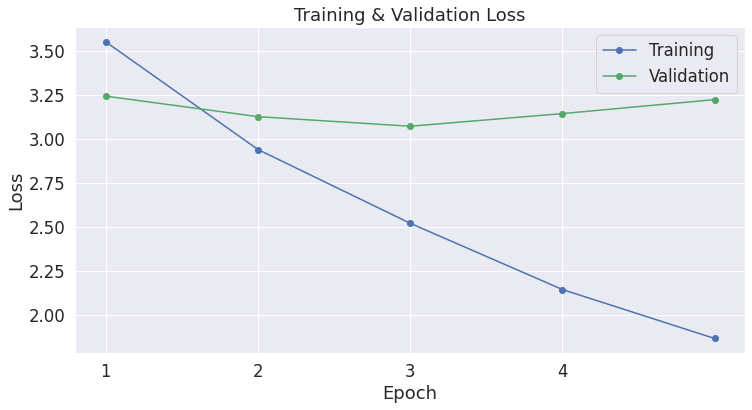

In [ ]:
import matplotlib.pyplot as plt

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [ ]:
# 파라미터 표시
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The GPT-2 model has 148 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (42006, 768)
transformer.wpe.weight                                   (2048, 768)

==== First Transformer ====

transformer.h.0.ln_1.weight                                   (768,)
transformer.h.0.ln_1.bias                                     (768,)
transformer.h.0.attn.c_attn.weight                       (768, 2304)
transformer.h.0.attn.c_attn.bias                             (2304,)
transformer.h.0.attn.c_proj.weight                        (768, 768)
transformer.h.0.attn.c_proj.bias                              (768,)
transformer.h.0.ln_2.weight                                   (768,)
transformer.h.0.ln_2.bias                                     (768,)
transformer.h.0.mlp.c_fc.weight                          (768, 3072)
transformer.h.0.mlp.c_fc.bias                                (3072,)
transformer.h.0.mlp.c_proj.weight                        (3072

In [ ]:
# 모델 저장

#output_dir = '/content/drive/MyDrive/5조_파이널PJT/코드/model_result/gpt3_1'

# 디렉토리 만들기
#if not os.path.exists(output_dir):
#    os.makedirs(output_dir)

#print("Saving model to %s" % output_dir)

# 모델, 토크나이저 등 저장
#model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
#model_to_save.save_pretrained(output_dir)
#tokenizer_gpt3.save_pretrained(output_dir)

Saving model to /content/drive/MyDrive/model_save


('/content/drive/MyDrive/model_save/tokenizer_config.json',
 '/content/drive/MyDrive/model_save/special_tokens_map.json',
 '/content/drive/MyDrive/model_save/vocab.txt',
 '/content/drive/MyDrive/model_save/added_tokens.json')

In [ ]:
#!ls -l --block-size=K /content/drive/MyDrive/5조_파이널PJT/코드/model_result/gpt3_1

total 513971K
-rw------- 1 root root      1K Mar  4 08:35 added_tokens.json
-rw------- 1 root root      1K Mar  4 08:35 config.json
-rw------- 1 root root 513632K Mar  4 08:35 pytorch_model.bin
-rw------- 1 root root      1K Mar  4 08:35 special_tokens_map.json
-rw------- 1 root root      1K Mar  4 08:35 tokenizer_config.json
-rw------- 1 root root    337K Mar  4 08:35 vocab.txt


In [ ]:
#!ls -l --block-size=M /content/drive/MyDrive/5조_파이널PJT/코드/model_result/gpt3_1/pytorch_model.bin

-rw------- 1 root root 502M Mar  4 08:35 /content/drive/MyDrive/model_save/pytorch_model.bin


In [ ]:
# !cp -r /content/drive/MyDrive/5조_파이널PJT/코드/model_result/gpt3_1 $data_dir

cp: missing destination file operand after './model_save/'
Try 'cp --help' for more information.


In [ ]:
# 구글 드라이브에서 모델, 토크나이저 불러오기

#model = GPT2LMHeadModel.from_pretrained('/content/drive/MyDrive/5조_파이널PJT/코드/model_result/gpt3_1')
# gpt3-kor-small_based_on_gpt2
#from transformers import BertTokenizerFast, GPT2LMHeadModel
#tokenizer = BertTokenizerFast.from_pretrained('/content/drive/MyDrive/5조_파이널PJT/코드/model_result/gpt3_1')
#input_ids = tokenizer.encode("text to tokenize")[1:]  # remove cls token

# Generate Text

* generate 함수 


In [ ]:
device = torch.device("cuda")
model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
model = model.to(device)

In [ ]:
model.eval()

prompt = "<|startoftext|> <발라드> 배고프다 "
generated = torch.tensor(tokenizer_gpt3.encode(prompt)[1:]).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(
                                generated, 
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,   
                                top_k=50, 
                                max_length = 300,
                                top_p=0.95, 
                                num_return_sequences=2,
                                repetition_penalty=1.2
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer_gpt3.decode(sample_output, skip_special_tokens=True)))

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


tensor([[42000, 42003, 40639,  8013,     3]], device='cuda:0')
0: 배고프다 니 생각에 늦은 저녁 <br> 괜히 혼잣말해 본 말 <br> 그냥 뭐 좀 먹으러 나가볼까 <br> 아님 우리 오랜만에 만나도 돼 <br> 딱히 할 말도 없던 밤 <br> 뜬금없이 또 설레어 <br> 너와 갔던 식당도 안 갔어 <br> 뭐가 그리 바빴는데 <br> 왜 이렇게 먹었을까 <br> 니가 좋아하던 그 포장마차가 그립다 <br> 다시 너를 보면 눈물이 날 것 같아 <br> 오늘따라 니가 보고 싶다 <br> 그냥 평소처럼 널 만나러 가는 길 <br> 너에게 들었던 기억들 <br> 다 털어내고 나와야 할까 봐 <br> 조금 멍청히 앉아있어도 <br> 니가 자꾸만 생각나 <br> 오늘도 역시 그랬나봐 <br> 니가 좋아하던 그 포장마차 <br> 그게 그렇게 좋았었는데 <br> 왜 이리 됐을까 <br> 니가 싫어했던 그


1: 배고프다 배고파 라면을 꺼내 본다 <br> 음 음 네 생각이 나 라라 라라라라라라라라 <br> 음 네 생각하면서 다시 먹는다 <br> 음 그래 난 라면이 좋아 <br> 너라면 어디서든 잘 먹힐 것 같아 <br> 오늘처럼 비오는 거릴 걷고 싶어 <br> 비도 오면 좋겠어 그냥 같이 우산 속에 울어도 돼 <br> 아무도 모르게 밤이 찾아오면 <br> 너만 생각나서 비가 오나 봐 <br> 지금쯤이면 넌 다 먹었을 텐데 <br> 음 그래 괜찮아 너는 맛있었잖아 <br> 너도 가끔 생각나니 너의 집 앞에도 <br> 우리가 자주 가던 식당들도 <br> 이젠 거의 모두 내 것이 된 것 같아 <br> 아직도 나는 잘 모르겠어 네가 뭘 알아 이런 바보야 <br> 왜 모르니까 난 아직 안먹어봐도 <br> 빨리 먹고 싶은 건 똑같은




#발라드 테스트

In [ ]:
prompt = "<|startoftext|> <발라드> 배고프다 "
generated = torch.tensor(tokenizer_gpt3.encode(prompt)[1:]).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(
                                generated, 
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,   
                                top_k=50, 
                                max_length = 300,
                                top_p=0.95, 
                                num_return_sequences=3,
                                repetition_penalty=1.2
                                )

for i, sample_output in enumerate(sample_outputs):
  result = "{}: {}\n\n".format(i, tokenizer_gpt3.decode(sample_output, skip_special_tokens=True))
  result = re.sub(r"<br>", "\n", result)
  print(result)

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


tensor([[42000, 42003, 40639,  8013,     3]], device='cuda:0')
0: 배고프다 배고파 빨리뚱동아 
 니가 좋아한단 맛집 찾아헤매 
 난 좀 괜찮아 일단 가보자 
 너의 작은 골목집이 있던 그 골목집에서 
 널 데려간 그곳이 신촌이야 
 너만 좋아하던 그 노래도 
 다시 너를 불러보는 지금 이 순간까지도 
 그때 우리가 생각나 니 말투 말버릇까지 
 하나하나가 내가 좋아했던 모든 것뿐이라서 
 그냥 무작정 달려왔어 
 왜 몰랐을까 정말 네가 보고싶었고 
 내가 싫어하던 그 음식들도 
 다 버리지 못한채 그대로였으니까 
 배 부르니 뭐좀 먹으러 갈까 
 너는 아는지 묻는 친구의 물음에도 
 태연한척 웃어줬었지 
 오 맛있겠다 기대했는데 실망하지마 
 적당히 먹자고 친구가 권


1: 배고프다 배고파 죽겠다 
 너한테 말해줄게 
 아무거나 상관없어 
 오늘 같은 날에 뭐해 
 네가 요즘 빠진 건 뭔지 알아 
 뭘 좋아할지도 모른 채 그냥 
 널 만나러 갔다 
 뭐가 그렇게 좋았었는지 
 무슨 향수가 좋다고 
 맘에 들어졌다고 거짓말 해봐 
 아무리 찾아봐도 없어 넌데 
 도대체 어디갔니 내가 아는 사람 
 없는거야 벌써 날 떠났는데 
 왜 연락이 안되니 다시 돌아 올 거잖아 
 도대체 왜 자꾸만 날 흔들어놔 
 나 없이도 괜찮은지 
 괜히 자존심 때문에 그러는거야 나는 
 원래 이런게 정이라 
 이런건 배려심이 너무 깊어서 
 겉으로는 쿨한척 하지만 속으로는 천박한 
 너를 봐선 안돼 안돼 내 옆에 선 너를 
 욕하지는


2: 배고프다 자꾸 이러면 안 되는데 
 그럼 더 짜겠지 뭐 
 오늘도 어김없이 또 너야 
 빨리 먹고 싶은 게 문제야 
 한 시간 반 기다린 것 같애 우리 
 들어가기 전에 이미 다 알고 있는지 
 오늘따라 네가 더 보고 싶어져 
 네가 좋아하는 것들로 좀 채워볼까 
 네 옆자리가 텅 비어버린 것도 아닌데 
 왠지 나만 아쉬운 기분이야 
 뭘 고를까 고민도 해봤어 어차피 넌 
 난 관심없으니까 


# 생성기

In [ ]:
def lyric_generator(gen, lyric):
  prompt = f"<|startoftext|> <{gen}> {lyric}"
  generated = torch.tensor(tokenizer_gpt3.encode(prompt)[1:]).unsqueeze(0)
  generated = generated.to(device)

  print(generated)

  sample_outputs = model.generate(
                                  generated, 
                                  #bos_token_id=random.randint(1,30000),
                                  do_sample=True,   
                                  top_k=50, 
                                  max_length = 300,
                                  top_p=0.95, 
                                  num_return_sequences=3,
                                  repetition_penalty=1.1
                                  )

  for i, sample_output in enumerate(sample_outputs):
    result = "{}: {}\n\n".format(i, tokenizer_gpt3.decode(sample_output, skip_special_tokens=True))
    result = re.sub(r"<br>", "\n", result)
    print(result)
  return

In [ ]:
lyric_generator('댄스', '배고프다')

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


tensor([[42000, 42004, 40639,  8013,     3]], device='cuda:0')
0: 배고프다 니가 갑자기 생각이 나 
 그냥 그렇게 너의 생각에 
 빠져든 거다 그냥 그렇게 
 이제 난 뭘 할까 
 너의 생각을 하면서 뭘 할지 
 오늘밤 널 생각하면서 
 너를 먼저 잊기로 했다 나도 
 너에 대한 내 사랑을 
 조금씩 지우려고 해 
 매일 밤 내 방에 불을 켜놓고 
 어질러진 방에 넌 혼자 
 이 방안에서 또 혼자서 
 뭐를 할 건지 뭘 할지 
 오늘밤 널 생각하면서 
 좀 더 일찍 널 지워야 했는데 
 내일 되면 오겠지 
 아마 난 못 잊을 거야 
 오늘밤 널 생각하면서 
 좀 더 서둘러 널 지워야 하는데 
 어쩌면 이미 너는 다신 없을지도 몰라 
 우리 사랑했었던 시간들이 
 자꾸 다시 생각나서 
 이렇게 오늘도 나는 간다 
 후회로 가득했던


1: 배고프다 김치찌개를 또 먹고 
 허전한 마음에 새로 산 신발을 신고 
 오랜만에 콧바람을 불어 
 꽤나 괜찮은 하루였지 
 요즘도 날씨가 좋다고 하던데 
 그때가 너도 가끔 생각이 나니 
 내 생각에 나는 웃었지 
 그런 너를 보며 웃던 나는 
 참 어렸었지 우리들만 
 서로 다른 생각 속에 살았는데 
 언제부터였을까 널 사랑하게 된 걸까 
 나 태어나 처음 가슴 설레이던 날 
 네 목소리에 무너져 내릴 것 같았어 
 이제 와서 생각해보니 네가 참 그리워 
 참 많이 사랑했다는 말 못 지킨 나 
 너밖에 몰랐던 우리라서 
 더 많이 안아줘야 했는데 
 좋은 사람 생겼으니까 
 괜히 나만 든 거 같아 
 너 없는 하루하루는 왜 이렇게 긴 거야 
 가끔 멍


2: 배고프다 배고파 오늘도 너를 찾아왔어 
 익숙한 그 골목에 네가 딱 생겼어 
 원래 좋아하던 김치찌개도 
 처음이었어 너와 갔던 카페도 
 다시 못갈 것 같던 거리도 
 그냥 네가 좋아하던 옷들도 
 다신 못보겠지 
 나 오늘부터 1일 이라도 
 울까봐 겁나서 못가 오늘은 
 가기 싫다 꼭 들러야지 했던 
 좁은 골목